In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import yaml

from visuals import visuals
# pip install git+https://github.com/kumiori/visuals.git

# Postprocessing

In [2]:

from scipy.stats import linregress

def fit_loglog(x, y):
    """Fit a log-log curve to the given data."""
    # Perform linear regression on the log-transformed data
    log_x = np.log(x)
    log_y = np.log(y)
    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    
    # Calculate the fitted line in log-log space
    fitted_log_y = intercept + slope * log_x
    fitted_y = np.exp(fitted_log_y)
    
    return slope, intercept, fitted_y

def plot_reference_triangle(ax, n, x0, x1, scale_factor=1.1, spin='bottom_left', x10=1000, x00=450, y00=1.5, y10=.0010, linestyle = 'solid', color = 'k'):
    """
    Plot a reference triangle on a log-log plot to indicate a slope.

    Parameters:
    ax (matplotlib.axes.Axes): The axis to plot on.
    n (float): The slope of the reference line.
    x0 (float): The starting x value.
    x1 (float): The ending x value.
    scale_factor (float): Scale factor for the y values (default is 2/3).

    Returns:
    None
    """
    y0 = scale_factor * x0 ** n
    y1 = scale_factor * x1 ** n

    if spin == 'bottom_left':
        ax.plot([x0, x1], [y0, y0], 'k', lw=1)  # Horizontal line
        ax.plot([x1, x1], [y0, y1], 'k', lw=1)  # Vertical line
        ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)
        ax.text(x1 + x10, y1 + y10, f'{np.abs(n):.2}', color='black', fontsize=12, ha='center')
        ax.text(x0 + x00, (y0 + y1) / y00, f'1', color='black', fontsize=12, ha='center')
    elif spin == 'top_right':
        ax.plot([x0, x1], [y1, y1], 'k', lw=1)  # Horizontal line
        ax.plot([x0, x0], [y0, y1], 'k', lw=1)  # Vertical line
        ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)
        ax.text(x1 - x10, y1 + y10, f'1', color='black', fontsize=12, ha='center')
        ax.text(x0 - x00, (y0 + y1) / y00, f'{np.abs(n):.2}', color='black', fontsize=12, ha='center')
    else:
        raise ValueError("Invalid spin argument. Use 'bottom_left' or 'top_right'.")

    # ax.text(x1 + 300, y1, '1', color='black', fontsize=12, ha='center')
    # ax.text(x0 + 500, y0, f'{np.abs(1/n):.2}', color='black', fontsize=12, ha='center')

def plot_energy_terms(data, x_column="param_value", yscale="log", xscale="log", fig = None, axs = None, energy_terms = ["bending", "membrane", "coupling", "external_work"]):
    """
    Plot energy terms (bending, membrane, coupling, external work) vs a parameter.
    """
    if fig is None and axs is None:
        fig, axs = plt.subplots(1, 1, figsize=(12, 8))

    for energy_type in energy_terms:
        axs.plot(
            data[x_column],
            data[energy_type],
            label=f"{energy_type.capitalize()} Energy",
            marker="o",
        )
    axs.set_title("Energy Terms vs Parameter")
    axs.set_xlabel("$$\\beta = R/h$$")
    axs.set_ylabel("Energy")
    axs.set_yscale(yscale)
    axs.set_xscale(xscale)
    axs.legend()
    # axs.grid(True)
    # axs.show()
    return fig, axs

def plot_residuals(data, x_column="param_value", y_column="snes_final_residual_norm"):
    """
    Plot the residual norm vs a parameter.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(data[x_column], data[y_column], label="Residual Norm", marker="o")
    plt.title("Solver Residual Norm vs Parameter")
    plt.xlabel("$$\\beta = R/h$$")
    plt.ylabel("Residual Norm")
    plt.yscale("log")
    plt.xscale("log")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_norms_with_penalization(data, x_column="param_value"):
    """
    Plot norms with error bars representing the absolute values of penalization terms.

    Args:
        data (pd.DataFrame): Experimental data containing norms and penalization terms.
        x_column (str): Column name for the x-axis values (e.g., parameter values).
    """
    fig, axs = plt.subplots(1, 1, figsize=(12, 8))

    # Extract data for norms and penalization terms
    v_norm = data["v_H2"]
    w_norm = data["w_H2"]
    x_values = data[x_column]

    # Penalization terms for bulk and boundary
    v_bulk_penalization = data["dgv"].abs()
    v_boundary_penalization = data["bcv"].abs()
    w_bulk_penalization = data["dgw"].abs()
    w_boundary_penalization = data["bcw"].abs()

    # Plot norms with error bars
    axs.errorbar(
        x_values,
        v_norm,
        yerr=[v_bulk_penalization, v_boundary_penalization],
        fmt="o",
        label="Norm of v (H2)",
        capsize=5,
    )
    axs.errorbar(
        x_values,
        w_norm,
        yerr=[w_bulk_penalization, w_boundary_penalization],
        fmt="o",
        label="Norm of w (H2)",
        capsize=5,
    )

    # Customize the plot
    axs.set_title("Norms with Penalization Terms as Error Bars")
    axs.set_xlabel("Parameter Value")
    axs.set_ylabel("Norm Value (L2)")
    axs.set_xscale("log")  # Log scale for better visibility
    axs.set_yscale("log")
    axs.legend()
    axs.grid(True)
    
    return fig, axs
    
def plot_solver_stats(data, x_column="param_value"):
    """
    Plot solver statistics such as iterations and convergence reasons.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(
        data[x_column],
        data["snes_iterations"],
        label="SNES Iterations",
        marker="o",
    )
    plt.plot(
        data[x_column],
        data["ksp_iterations_last"],
        label="KSP Iterations Last",
        marker="o",
    )
    plt.title("Solver Statistics vs Parameter")
    plt.xlabel("$$\\beta = R/h$$")
    plt.ylabel("Number of Iterations")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_norms(data, x_column="param_value"):
    """
    Plot the norms (L2, H1, H2) for the fields v and w.
    """
    # Identify indices for successful and unsuccessful convergence
    converged_indices = data["snes_convergence_reason"] >= 0
    non_converged_indices = data["snes_convergence_reason"] < 0

    # Define marker styles
    success_marker = "o"  # Circle for successful convergence
    failure_marker = "x"  # Cross for non-convergence

    fig, axs = plt.subplots(1, 1, figsize=(12, 8))
    
    # Plot norms for v
    for norm_type in ["v_L2", "v_H1", "v_H2", "v_max"]:
        # Plot successfully converged points
        axs.plot(
            data[x_column][converged_indices],
            data[norm_type][converged_indices],
            label=f"Norm {norm_type} (v) - Success",
            marker=success_marker,
            linestyle="",
        )
        # Plot non-converged points
        axs.plot(
            data[x_column][non_converged_indices],
            data[norm_type][non_converged_indices],
            label=f"Norm {norm_type} (v) - Failure",
            marker=failure_marker,
            linestyle="",
        )

    # Plot norms for w
    for norm_type in ["w_L2", "w_H1", "w_H2", "w_max"]:
        # Plot successfully converged points
        axs.plot(
            data[x_column][converged_indices],
            data[norm_type][converged_indices],
            label=f"Norm {norm_type} (w) - Success",
            marker=success_marker,
            linestyle="",
        )
        # Plot non-converged points
        axs.plot(
            data[x_column][non_converged_indices],
            data[norm_type][non_converged_indices],
            label=f"Norm {norm_type} (w) - Failure",
            marker=failure_marker,
            linestyle="",
        )

    # Customize the plot
    axs.set_title("Norms of Fields vs Parameter")
    axs.set_xlabel("Parameter Value")
    axs.set_ylabel("Norm Value")
    axs.set_yscale("log")
    axs.set_xscale("log")
    axs.legend()
    # fig.grid(True)
    
    return fig, axs

def plot_penalization(data, x_column="param_value"):
    """
    Plot the penalization terms against the parameter values.
    """
    fig, axs = plt.subplots(1, 1, figsize=(12, 8))


    penalization_terms = ["dgw", "dgv", "dgc", "bcv", "bcw"]

    for term in penalization_terms:
        plt.plot(
            data[x_column],
            np.abs(data[term]),
            label=f"Penalization Term: {term.upper()}",
            marker="o",
        )

    plt.title("Penalization Terms vs Parameter")
    plt.xlabel("Parameter Value")
    plt.ylabel("Penalization Value")
    plt.yscale("log")  # Log scale for better visibility
    plt.xscale("log")
    plt.legend()
    plt.grid(True)
    
    return fig, axs

from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FuncFormatter

def plot_error_terms(data, x_column="param_value", yscale="log", xscale="log", fig = None, axs = None, 
                     error_terms = ["rel_error_membrane",
       "rel_error_bending", "rel_error_coupling"]):
    """
    Plot energy terms (bending, membrane, coupling, external work) vs a parameter.
    """
    if fig is None and axs is None:
        fig, axs = plt.subplots(1, 1, figsize=(12, 8))

    for error_type in error_terms:
        axs.scatter(
            data[x_column],
            data[error_type],
            label=f"{error_type.capitalize()}",
            marker="o",
        )
    axs.set_title("Error terms vs Parameter")
    axs.set_xlabel("$$\\beta = R/h$$")
    axs.set_ylabel("Error")
    axs.set_yscale(yscale)
    axs.set_xscale(xscale)
    axs.legend()
    axs.yaxis.set_major_formatter(PercentFormatter(1, decimals = 0))  # Format y-axis as percentage
    # axs.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%} %'.format(y))) 

    # axs.grid(True)
    # axs.show()
    return fig, axs

def exact_energy_dipole(parameters, h, adimensional=True):
    # it should depend on the signs as well
    distance = np.linalg.norm(
        np.array(parameters["loading"]["points"][0])
        - np.array(parameters["loading"]["points"][1])
    )
    # assert h == parameters["model"]["thickness"]
    energy_scale = 1
    if adimensional:
        energy_scale = parameters["model"]["E"] * h ** 5 / parameters["geometry"]["radius"] ** 2    
    return (
        1/energy_scale * 
        parameters["model"]["E"]
        * h 
        * parameters["geometry"]["radius"] ** 2
        / (8 * np.pi)
        * distance**2
        * (np.log(4 + distance**2) - np.log(4 * distance))
    )

### Compression monopole

In [3]:
data_file = "experiment_Parametric_compression_monopole/output/01bba0/experimental_data.pkl"  # Update with your file path
experimental_data = pd.read_pickle(data_file)

# Display basic information about the dataset
print("Loaded Data Information:")
print(experimental_data.info())

# ## Data Overview
# Show the first few rows of the data for an overview
display(experimental_data.head())


Loaded Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   signature                  10 non-null     object 
 1   param_value                10 non-null     float64
 2   total                      10 non-null     float64
 3   bending                    10 non-null     float64
 4   membrane                   10 non-null     float64
 5   coupling                   10 non-null     float64
 6   external_work              10 non-null     float64
 7   v_L2                       10 non-null     float64
 8   w_L2                       10 non-null     float64
 9   v_H1                       10 non-null     float64
 10  w_H1                       10 non-null     float64
 11  v_H2                       10 non-null     float64
 12  w_H2                       10 non-null     float64
 13  v_max                      1

,signature,param_value,total,bending,membrane,coupling,external_work,v_L2,w_L2,v_H1,...,bcv,bcw,snes_iterations,snes_convergence_reason,snes_final_residual_norm,snes_function_evaluations,ksp_iterations_last,ksp_convergence_reason,ksp_final_residual_norm,ksp_type
0,cf1c9cfe0dcbb58abaad1dfc914adcc7,0.100000,-993393.896750,0.002978,993393.896679,-0.003049,-0.000065,127.379114,0.000411,376.098087,...,-175.185231,-3.452736e-07,2,3,0.000319,3,1,4,0.0,preonly
1,805dec73999c7610147320c5ca4d5158,0.278256,-993395.974967,0.023058,993395.974417,-0.023609,-0.000506,127.379260,0.001143,376.098514,...,-175.185574,-2.673362e-06,2,3,0.002470,3,1,4,0.0,preonly
2,5e3e309290f54fe361b6dac0b3816d06,0.774264,-993393.410138,0.178544,993393.405875,-0.182807,-0.003918,127.379079,0.003181,376.097988,...,-175.185139,-2.070075e-05,3,3,0.000008,4,1,4,0.0,preonly
3,f5ec2a3577658e5529f6209ad35a349b,2.154435,-993392.206614,1.383087,993392.173597,-1.416104,-0.030338,127.378993,0.008852,376.097744,...,-175.184860,-1.603981e-04,3,3,0.000008,4,1,4,0.0,preonly
4,6878815850d7375c3f5b03f459feabc2,5.994843,-993382.849479,10.748487,993382.593129,-11.004838,-0.235214,127.378322,0.024665,376.095847,...,-175.182697,-1.248888e-03,3,3,0.000108,4,1,4,0.0,preonly


/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_34896/867567752.py:42: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_34896/867567752.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)


0

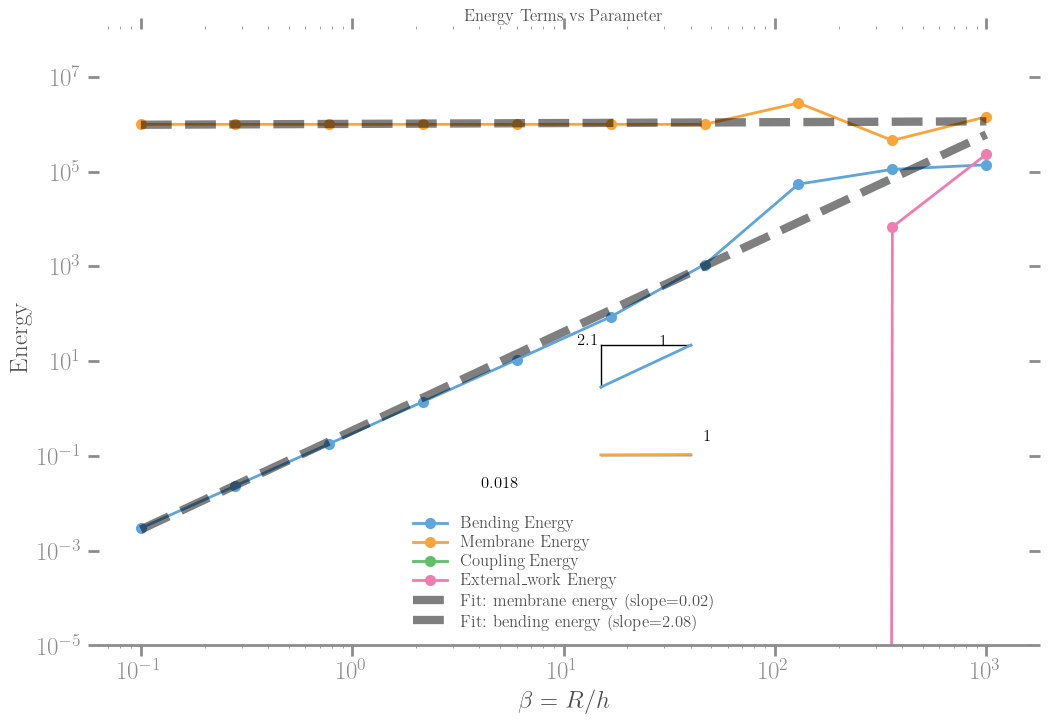

In [4]:
# ## Data Analysis
# ### Energy Analysis
# Plot energy terms
fig, axs = plot_energy_terms(experimental_data)

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["membrane"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = -8, x00=10, y10 = .10, y00=10, scale_factor=.1, color='C1', spin='top_right')
axs.plot(experimental_data["param_value"], _fit, label=f"Fit: membrane energy (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["bending"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = 10, x00=2, y10 = .001, y00=1.1, scale_factor=.01, color='C0', spin='top_right')
axs.plot(experimental_data["param_value"], _fit, label=f"Fit: bending energy (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

axs.legend()
# _slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["w_H2"])
# plot_reference_triangle(axs, _slope, 15, 40, x10 = 10, x00=2, y10 = .001, y00=1.1, scale_factor=.6, color='C5', spin='top_right')
# axs.plot(experimental_data["param_value"], _fit, label=f"Fit: H2 Norm of w (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

# axs.set_xlim(1e1, 1e2)
# axs.axvline(1e2, color='k', linestyle='--', alpha=0.5)
axs.set_ylim(1e-5, 1e8)
visuals.setspines0()

# fig.savefig(f"{output_folder}/{series}_energy_terms.pdf", bbox_inches='tight')
# fig.savefig(f"{output_folder}/{series}_energy_terms.png", bbox_inches='tight')

# print(f"Saved to {output_folder}/{series}_energy_terms")

/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_34896/867567752.py:42: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_34896/867567752.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)


AttributeError: module 'visuals.visuals' has no attribute 'setspines1'

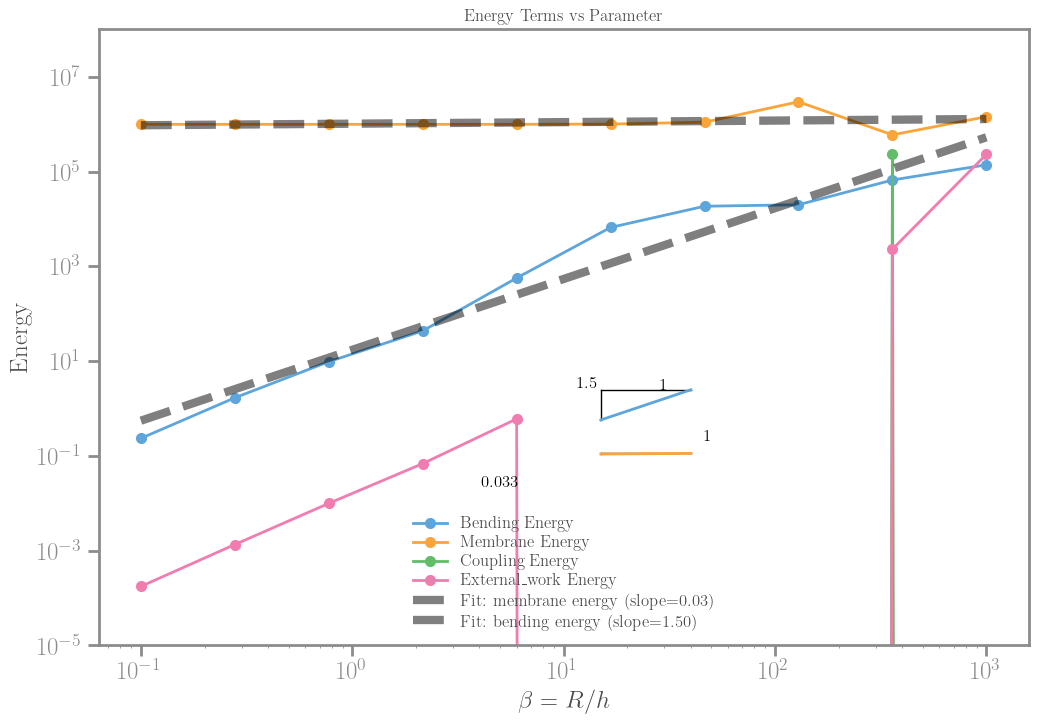

In [6]:
data_file = "experiment_Parametric_compression_monopole/output/db8155/experimental_data.pkl"  # Update with your file path
experimental_data = pd.read_pickle(data_file)

# ## Data Analysis
# ### Energy Analysis
# Plot energy terms
fig, axs = plot_energy_terms(experimental_data)

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["membrane"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = -8, x00=10, y10 = .10, y00=10, scale_factor=.1, color='C1', spin='top_right')
axs.plot(experimental_data["param_value"], _fit, label=f"Fit: membrane energy (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["bending"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = 10, x00=2, y10 = .001, y00=1.1, scale_factor=.01, color='C0', spin='top_right')
axs.plot(experimental_data["param_value"], _fit, label=f"Fit: bending energy (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

axs.legend()
# _slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["w_H2"])
# plot_reference_triangle(axs, _slope, 15, 40, x10 = 10, x00=2, y10 = .001, y00=1.1, scale_factor=.6, color='C5', spin='top_right')
# axs.plot(experimental_data["param_value"], _fit, label=f"Fit: H2 Norm of w (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

# axs.set_xlim(1e1, 1e2)
# axs.axvline(1e2, color='k', linestyle='--', alpha=0.5)
axs.set_ylim(1e-5, 1e8)
visuals.setspines1()

# fig.savefig(f"{output_folder}/{series}_energy_terms.pdf", bbox_inches='tight')
# fig.savefig(f"{output_folder}/{series}_energy_terms.png", bbox_inches='tight')

# print(f"Saved to {output_folder}/{series}_energy_terms")

/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_34896/867567752.py:42: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_34896/867567752.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)


0

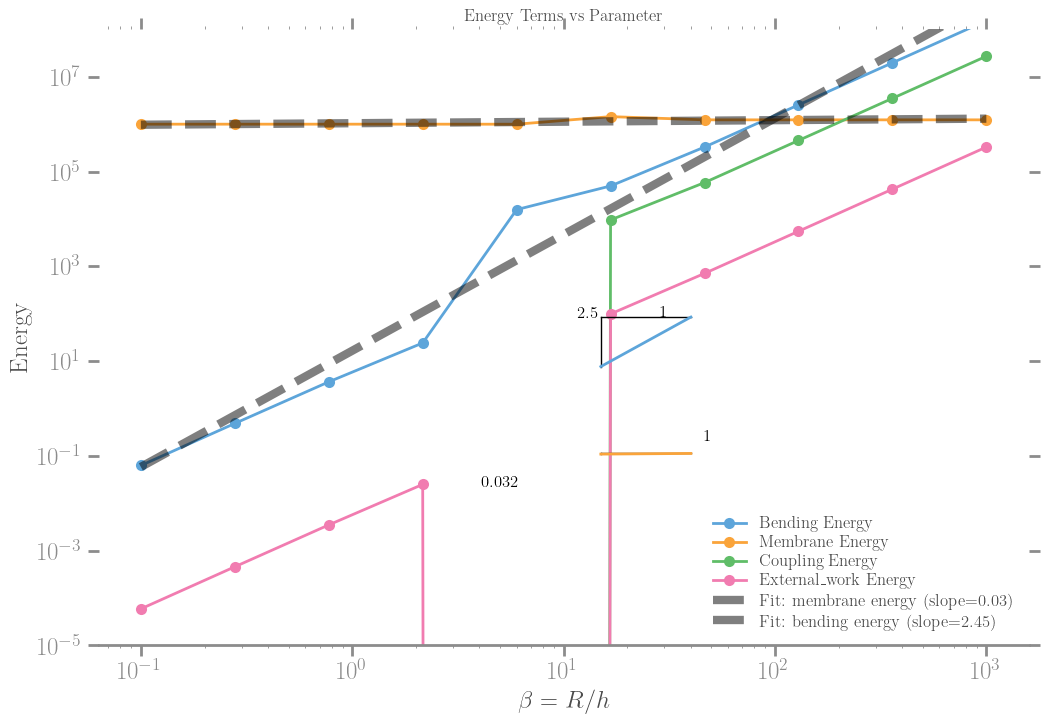

In [8]:
data_file = "experiment_Parametric_compression_monopole/output/ab7735/experimental_data.pkl"  # Update with your file path
experimental_data = pd.read_pickle(data_file)

fig, axs = plot_energy_terms(experimental_data)

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["membrane"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = -8, x00=10, y10 = .10, y00=10, scale_factor=.1, color='C1', spin='top_right')
axs.plot(experimental_data["param_value"], _fit, label=f"Fit: membrane energy (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["bending"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = 10, x00=2, y10 = .001, y00=1.1, scale_factor=.01, color='C0', spin='top_right')
axs.plot(experimental_data["param_value"], _fit, label=f"Fit: bending energy (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

axs.legend()

axs.set_ylim(1e-5, 1e8)
visuals.setspines0()



---

In [184]:
!ls experiment_Parametric_Relative_Work/output/cd2171

0454b9c3548fe88c16ebe21e3779a31c 82f9b535bfa9bedd6fdf0f3eef4ee2e9
059799d1a8ffa064f31e4cac10dc4632 837cd099bdfd8f79112e556678fcb915
07b2898a00edb0c14ac6d4e0e888a604 85b0a43b387d23a438ca28b69e41fe6b
084ace5f901831ad43878cc68eb91132 8746037f85497a5a7a685f20b33359c8
0cf20c537cfb67f3176f0c46aebfaa69 87ae7cc9c728e3e1210e4cbef6d55187
0f89505db9dd7918038175e0178b4e92 893f01c09e5101ee7f68de4f7730a73e
121a37a534c438ed030b19dff9714f44 8c064c2581f74bde4e9df7d0ec44b5ab
13bbe4606c685f08f2d4afbce633010d 8de830a3034925ccb5d84aed7a0d5f2f
17171376731d28b052468f68e17579d6 90337a27acf9996a6cc72db5382906b2
19cc6ba775d8d6e4a67e5a1a36303a3f 92aec5f3a369704e633d4bd33560bcac
1acd844fdf3be12a69de878871aa5ed9 98deef8ee5d6b6259f012f454c38b2ce
1d23b992af299195fcea37761a914b19 997c6bd5ba8e3e33f05951e0357571d7
23a6f980c823f0eaefcba1683b345667 9e34bbb3afd9c3ea0cdb76240189be54
26a7e0ecf8a64b02baebf571913ca1d8 9efd7ce2a028f1ff8cab4cc3b2546978
26c9bdc1efdc2fbc79cd8fb60a1dc97c 9fc9daf9c03b098917a53bcda1d1f361
34d3e3f885

In [185]:
data_file = "experiment_Parametric_Relative_Work/output/cd2171/experimental_data.pkl"  # Update with your file path
experimental_data = pd.read_pickle(data_file)

# Display basic information about the dataset
print("Loaded Data Information:")
print(experimental_data.info())

# ## Data Overview
# Show the first few rows of the data for an overview
display(experimental_data.head())


Loaded Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   signature                  100 non-null    object 
 1   param_value                100 non-null    float64
 2   total                      100 non-null    float64
 3   bending                    100 non-null    float64
 4   membrane                   100 non-null    float64
 5   coupling                   100 non-null    float64
 6   external_work              100 non-null    float64
 7   v_L2                       100 non-null    float64
 8   w_L2                       100 non-null    float64
 9   v_H1                       100 non-null    float64
 10  w_H1                       100 non-null    float64
 11  v_H2                       100 non-null    float64
 12  w_H2                       100 non-null    float64
 13  dgw                       

,signature,param_value,total,bending,membrane,coupling,external_work,v_L2,w_L2,v_H1,...,bcv,bcw,snes_iterations,snes_convergence_reason,snes_final_residual_norm,snes_function_evaluations,ksp_iterations_last,ksp_convergence_reason,ksp_final_residual_norm,ksp_type
0,ebae31c93c239ac9dbc30c0ea0195f05,10.000000,-39.973182,50.911636,156.142000,65.257182,231.035894,1.660340,2.450821,4.808196,...,-0.090803,-0.712870,6,3,0.000002,7,1,4,0.0,preonly
1,539315ffeaeb6890a6cc55f2b6d2ccb0,10.476158,-63.388264,48.926911,176.110664,63.795489,224.172524,1.756208,2.373534,5.095098,...,-0.100815,-0.695554,6,3,0.000002,7,1,4,0.0,preonly
2,d71838165a46ab6ea4d3639db32780be,10.974988,-90.934782,46.877670,200.062533,62.250081,217.014296,1.864361,2.293186,5.418580,...,-0.112714,-0.677352,6,3,0.000001,7,1,4,0.0,preonly
3,05bf273caf562a35c7f05a16ad2d606f,11.497570,-123.441975,44.777143,228.844389,60.625271,209.596180,1.986229,2.210198,5.782826,...,-0.126898,-0.658334,6,3,0.000001,7,1,4,0.0,preonly
4,80a9ec55c33872c613692b914415c1c6,12.045035,-161.913909,42.640372,263.481333,58.927052,201.960105,2.123356,2.125065,6.192334,...,-0.143850,-0.638594,6,3,0.000001,7,1,4,0.0,preonly


## Experiment ...

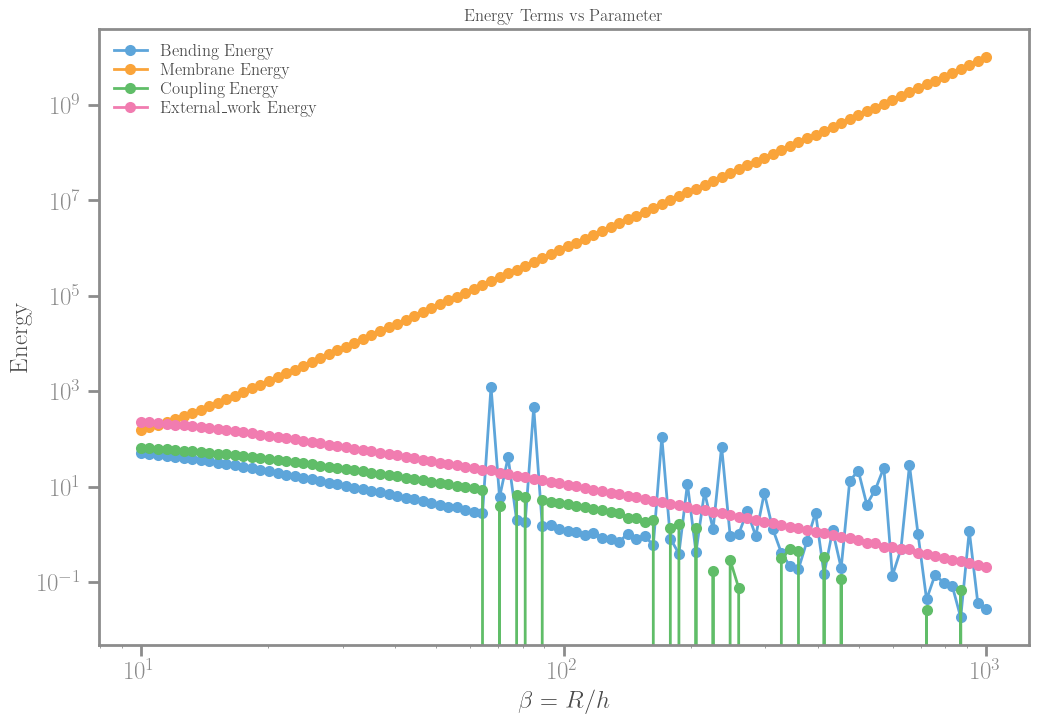

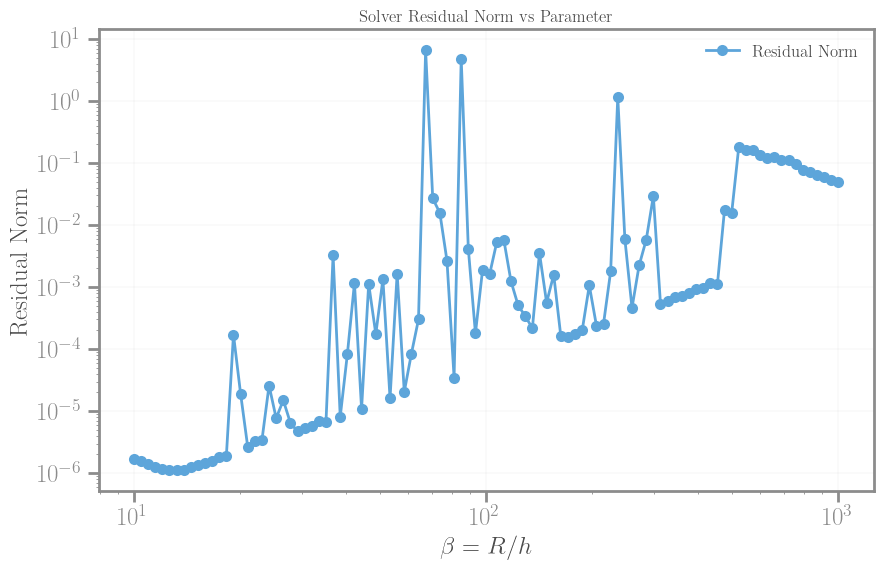

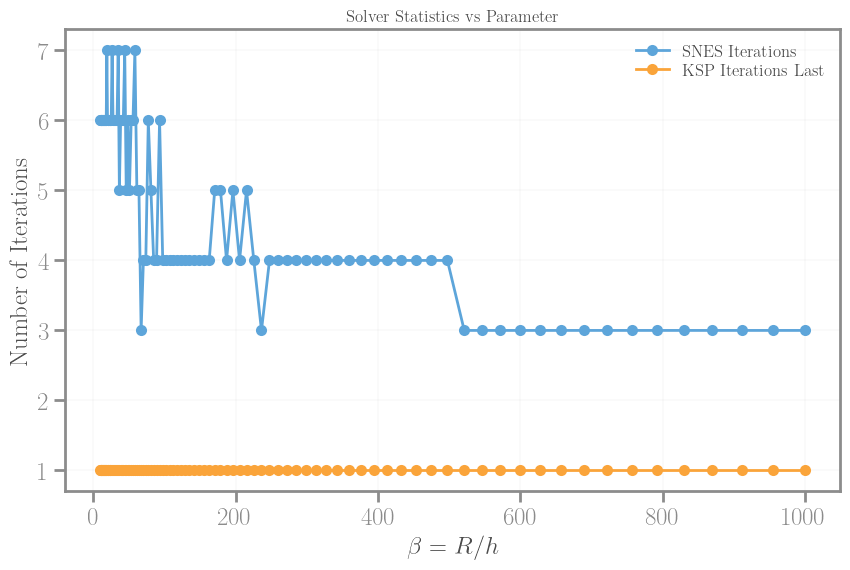

KeyError: 'v_max'

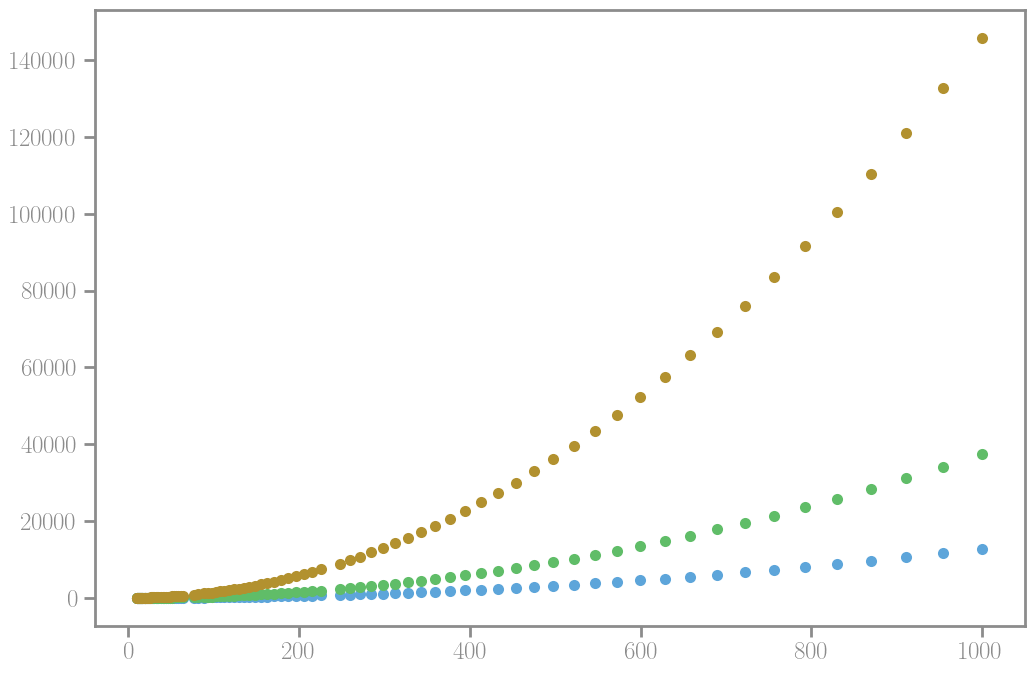

In [187]:

# ## Data Analysis
# ### Energy Analysis
# Plot energy terms
plot_energy_terms(experimental_data)

# ### Residual Analysis
# Plot the residual norm
plot_residuals(experimental_data)

# ### Solver Statistics
# Plot solver statistics
plot_solver_stats(experimental_data)

# ### Norms Analysis
# Plot the norms (L2, H1, H2) for fields v and w
plot_norms(experimental_data)

# ### Penalization Terms Analysis
# Plot the penalization terms
plot_penalization(experimental_data)


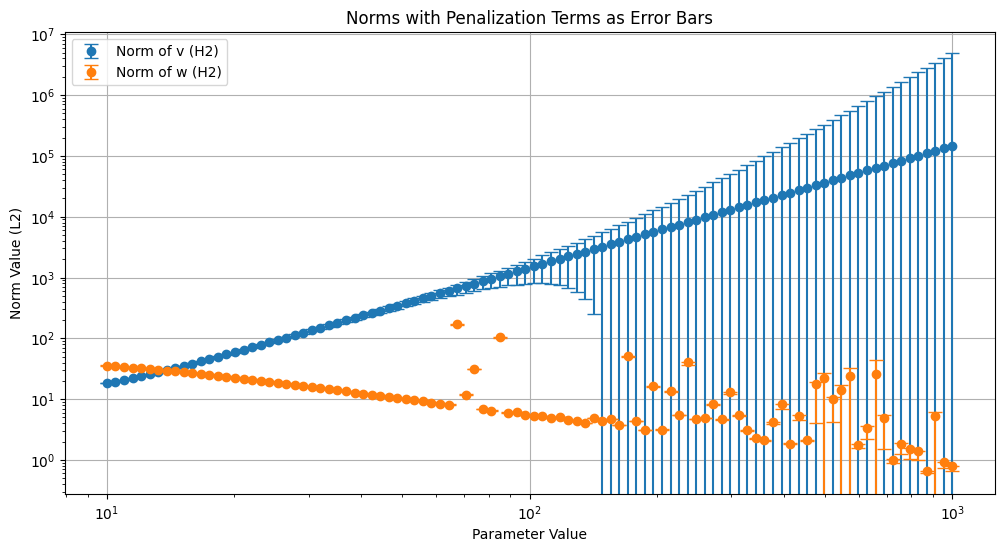

In [ ]:
# ### Norms with Penalization Terms
fig, axs = plot_norms_with_penalization(experimental_data)

<ErrorbarContainer object of 3 artists>

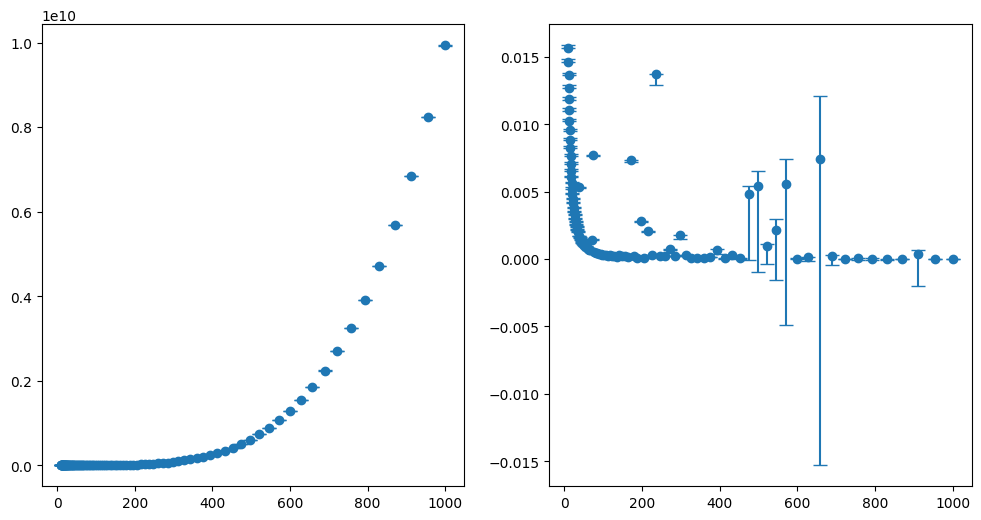

<Figure size 1200x600 with 0 Axes>

In [ ]:
data= experimental_data
x_column="param_value"
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plt.figure(figsize=(12, 6))

# Extract data for norms and penalization terms
v_energy = data["membrane"]
w_energy = data["bending"]
x_values = data[x_column]

# Penalization terms for bulk and boundary
v_bulk_penalization = data["dgv"].abs()
v_boundary_penalization = data["bcv"].abs()
w_bulk_penalization = data["dgw"].abs()
w_boundary_penalization = data["bcw"].abs()

# Plot norms with error bars
axs[0].errorbar(
    x_values,
    v_energy,
    yerr=[v_bulk_penalization, v_boundary_penalization],
    fmt="o",
    label="Energy of v (H2)",
    capsize=5,
)
axs[1].errorbar(
    x_values,
    w_energy,
    yerr=[w_bulk_penalization, w_boundary_penalization],
    fmt="o",
    label="Energy of w (H2)",
    capsize=5,
)

# Customize the plot
# plt.title("Norms with Penalization Terms as Error Bars")
# plt.xlabel("Parameter Value")
# plt.ylabel("Norm Value (L2)")
# # plt.xscale("log")  # Log scale for better visibility
# # plt.yscale("log")
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# experimental_data["param_value"]
experimental_data["w_H2"]

0     35.183898
1     34.477449
2     33.733550
3     32.954729
4     32.144308
        ...    
95     1.396130
96     0.653744
97     5.236539
98     0.922580
99     0.791326
Name: w_H2, Length: 100, dtype: float64

In [ ]:
_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["w_H2"])
_slope, _intercept, _fit

(-0.5377257055499328,
 4.697176673405194,
 0     31.785731
 1     31.000526
 2     30.234717
 3     29.487827
 4     28.759387
         ...    
 95     2.952796
 96     2.879852
 97     2.808711
 98     2.739327
 99     2.671658
 Name: param_value, Length: 100, dtype: float64)

/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_87377/2772413595.py:44: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_87377/2772413595.py:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)


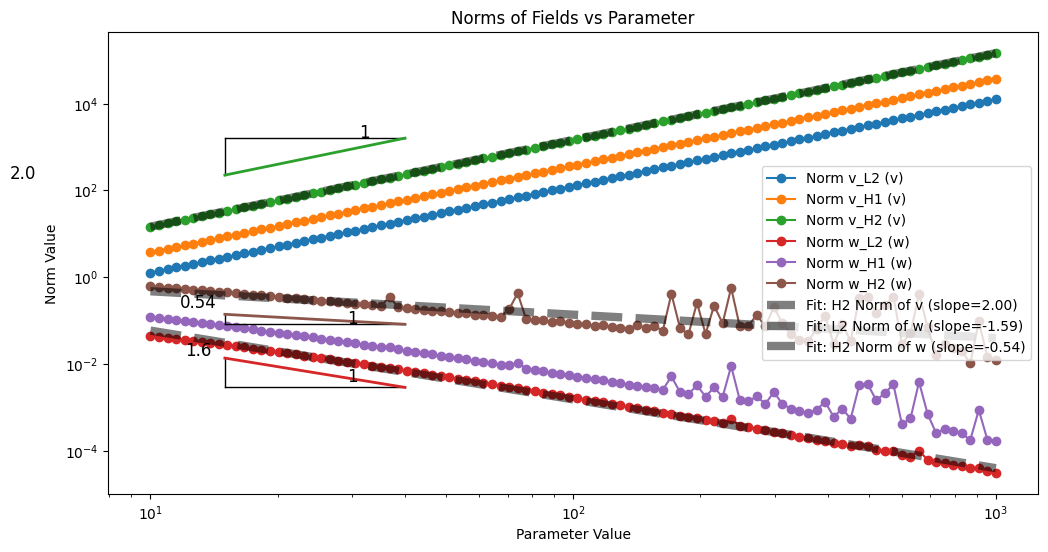

In [ ]:
fig, axs = plot_norms(experimental_data)

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["v_H2"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = 8, x00=10, y10 = .10, y00=10, scale_factor=1, color='C2', spin='top_right')
axs.plot(experimental_data["param_value"], _fit, label=f"Fit: H2 Norm of v (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["w_L2"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = 10, x00=2, y10 = .001, y00=1.1, scale_factor=1, color='C3', spin='top_right')
axs.plot(experimental_data["param_value"], _fit, label=f"Fit: L2 Norm of w (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["w_H2"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = 10, x00=2, y10 = .001, y00=1.1, scale_factor=.6, color='C5', spin='top_right')
axs.plot(experimental_data["param_value"], _fit, label=f"Fit: H2 Norm of w (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)


axs.legend()
# axs.set_xlim(1e-1, 1e4)
# axs.set_ylim(1e-4, 1e6)


In [ ]:
axs

<Axes: title={'center': 'Norms of Fields vs Parameter'}, xlabel='Parameter Value', ylabel='Norm Value'>

## Parametric, relative work, with uniform transverse load

In [ ]:
!ls experiment_Parametric_Relative_Work_constant_transverse/output/

00da40
0869de
0869de_energy_terms.pdf
13ca35
4e8ede
5af391
969e82
9be536
cd2171
mesh-07274142eb8b292d76bcef4d83631102.h5
mesh-07274142eb8b292d76bcef4d83631102.xdmf
mesh-2cbd1e6cc78ea060c9a8bab88fe77c36.h5
mesh-2cbd1e6cc78ea060c9a8bab88fe77c36.xdmf
mesh-68222a64c4a078b259698c295847c474.h5
mesh-68222a64c4a078b259698c295847c474.xdmf
mesh-6adbaa96b21b74e13564b972ece164ce.h5
mesh-6adbaa96b21b74e13564b972ece164ce.xdmf
mesh-9333197f9d87ea0a6e458d12f536aca7.h5
mesh-9333197f9d87ea0a6e458d12f536aca7.xdmf
mesh-a837d78fcbda9a8a9cf1170473551b85.h5
mesh-a837d78fcbda9a8a9cf1170473551b85.xdmf
mesh-ae7c428dd36716531b023465da8df770.h5
mesh-ae7c428dd36716531b023465da8df770.xdmf
mesh-c0075119f2c1685a97a2811934a5e529.h5
mesh-c0075119f2c1685a97a2811934a5e529.xdmf


In [212]:
data_file = "experiment_Parametric_Relative_Work_constant_transverse/output/0869de/experimental_data.pkl"  # Update with your file path
experimental_data = pd.read_pickle(data_file)

experimental_folder = os.path.dirname(data_file)
series = data_file.split("/")[-2]
output_folder = os.path.join(*[s for s in os.path.dirname(data_file).split('/')[0:2]])

with open(os.path.join(experimental_folder, 'parameters.yml')) as f:
    parameters = yaml.load(f, Loader=yaml.FullLoader)

# Display basic information about the dataset
print("Loaded Data Information:")
print(experimental_data.info())

# ## Data Overview
# Show the first few rows of the data for an overview
display(experimental_data.head())


Loaded Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   signature                  30 non-null     object 
 1   param_value                30 non-null     float64
 2   total                      30 non-null     float64
 3   bending                    30 non-null     float64
 4   membrane                   30 non-null     float64
 5   coupling                   30 non-null     float64
 6   external_work              30 non-null     float64
 7   v_L2                       30 non-null     float64
 8   w_L2                       30 non-null     float64
 9   v_H1                       30 non-null     float64
 10  w_H1                       30 non-null     float64
 11  v_H2                       30 non-null     float64
 12  w_H2                       30 non-null     float64
 13  v_max                      

,signature,param_value,total,bending,membrane,coupling,external_work,v_L2,w_L2,v_H1,...,bcv,bcw,snes_iterations,snes_convergence_reason,snes_final_residual_norm,snes_function_evaluations,ksp_iterations_last,ksp_convergence_reason,ksp_final_residual_norm,ksp_type
0,0369ff4264f88a207bcb31582544c76f,10.000000,-99.323885,0.015443,99.355813,0.016485,0.063851,1.273923,0.044354,3.761338,...,-0.017523,-0.000178,3,2,1.514758e-07,4,1,4,0.0,preonly
1,1262070b113dbe8900c45a54f1aa79ba,11.244372,-158.791293,0.012961,158.819496,0.015242,0.056390,1.610627,0.038855,4.755491,...,-0.028009,-0.000160,3,2,1.632096e-07,4,1,4,0.0,preonly
2,6d4cf628b96184f5dd6592f69aeda2e0,12.643591,-253.854289,0.010827,253.879064,0.013949,0.049526,2.036359,0.033853,6.012508,...,-0.044773,-0.000143,3,2,1.778893e-07,4,1,4,0.0,preonly
3,04b39c2ae6a7e2a9edff09c2c11bf1d6,14.216924,-405.820771,0.009006,405.842425,0.012648,0.043275,2.574650,0.029346,7.601865,...,-0.071572,-0.000127,3,2,1.915522e-07,4,1,4,0.0,preonly
4,ce9e62606464e353236609cc001b24ee,15.986039,-648.753613,0.007462,648.772447,0.011372,0.037632,3.255254,0.025321,9.611411,...,-0.114413,-0.000113,3,2,2.384468e-07,4,1,4,0.0,preonly


/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_85807/845257478.py:42: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_85807/845257478.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)


Saved to experiment_Parametric_Relative_Work_constant_transverse/output/0869de_energy_terms


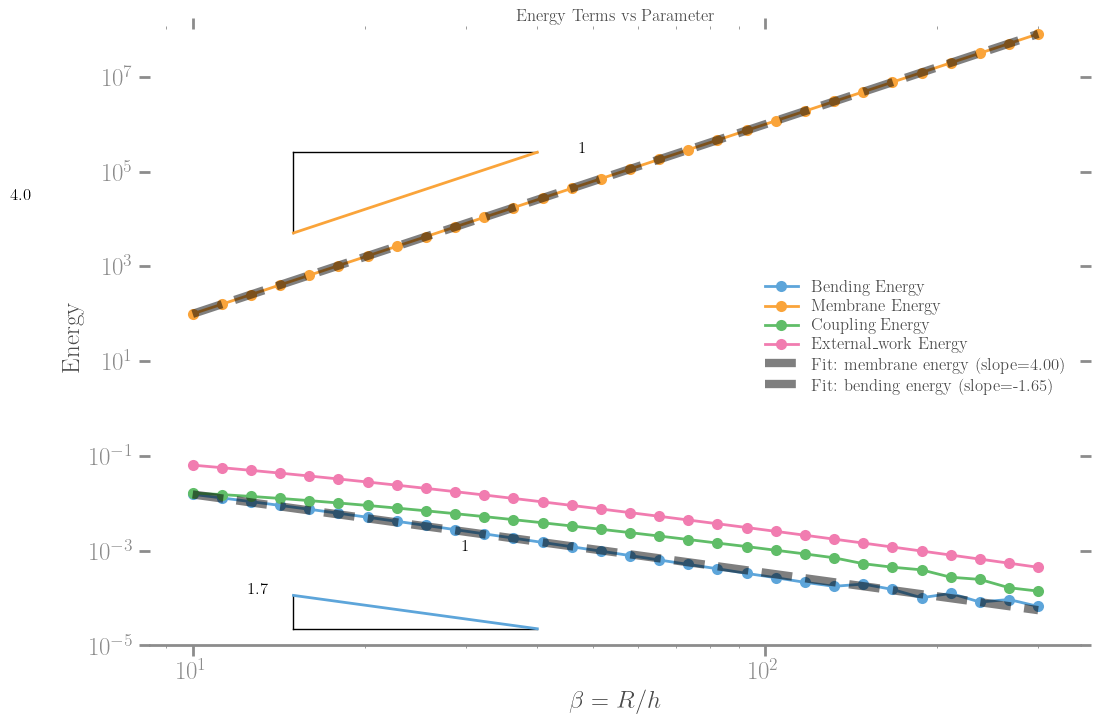

In [213]:
# ## Data Analysis
# ### Energy Analysis
# Plot energy terms
fig, axs = plot_energy_terms(experimental_data)

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["membrane"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = -8, x00=10, y10 = .10, y00=10, scale_factor=.1, color='C1', spin='top_right')
axs.plot(experimental_data["param_value"], _fit, label=f"Fit: membrane energy (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["bending"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = 10, x00=2, y10 = .001, y00=1.1, scale_factor=.01, color='C0', spin='top_right')
axs.plot(experimental_data["param_value"], _fit, label=f"Fit: bending energy (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

axs.legend()
# _slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["w_H2"])
# plot_reference_triangle(axs, _slope, 15, 40, x10 = 10, x00=2, y10 = .001, y00=1.1, scale_factor=.6, color='C5', spin='top_right')
# axs.plot(experimental_data["param_value"], _fit, label=f"Fit: H2 Norm of w (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

# axs.set_xlim(1e1, 1e2)
# axs.axvline(1e2, color='k', linestyle='--', alpha=0.5)
axs.set_ylim(1e-5, 1e8)
visuals.setspines0()

fig.savefig(f"{output_folder}/{series}_energy_terms.pdf", bbox_inches='tight')
fig.savefig(f"{output_folder}/{series}_energy_terms.png", bbox_inches='tight')

print(f"Saved to {output_folder}/{series}_energy_terms")

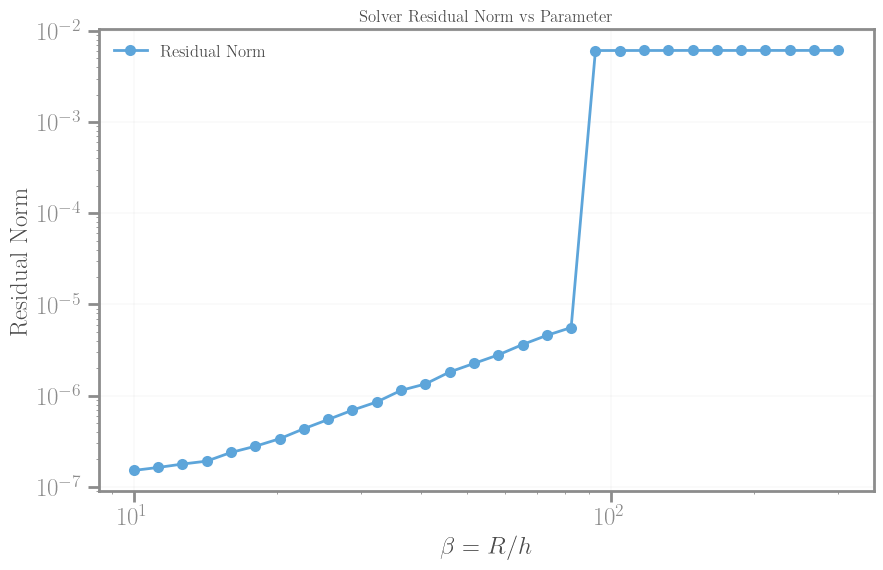

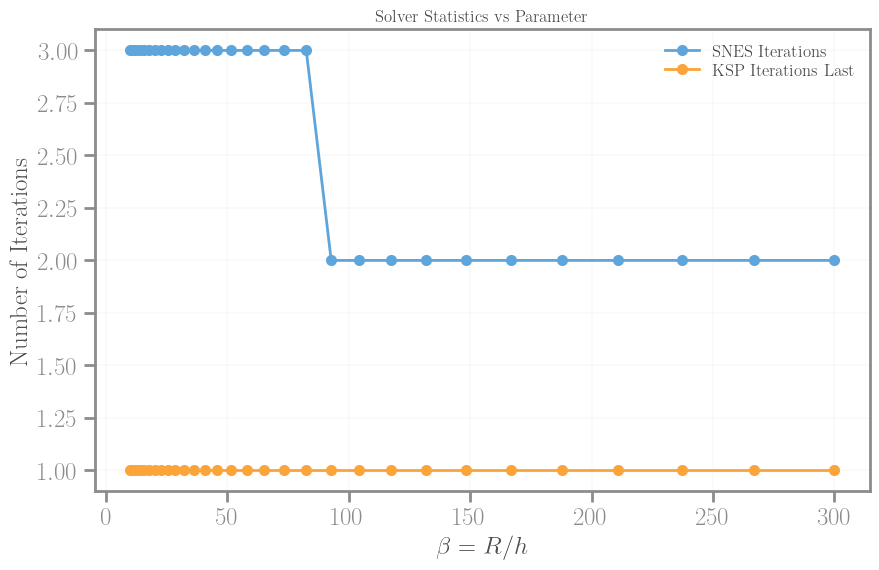

/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_85807/845257478.py:36: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_85807/845257478.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_85807/845257478.py:42: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  #

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Norms with Penalization Terms as Error Bars'}, xlabel='Parameter Value', ylabel='Norm Value (L2)'>)

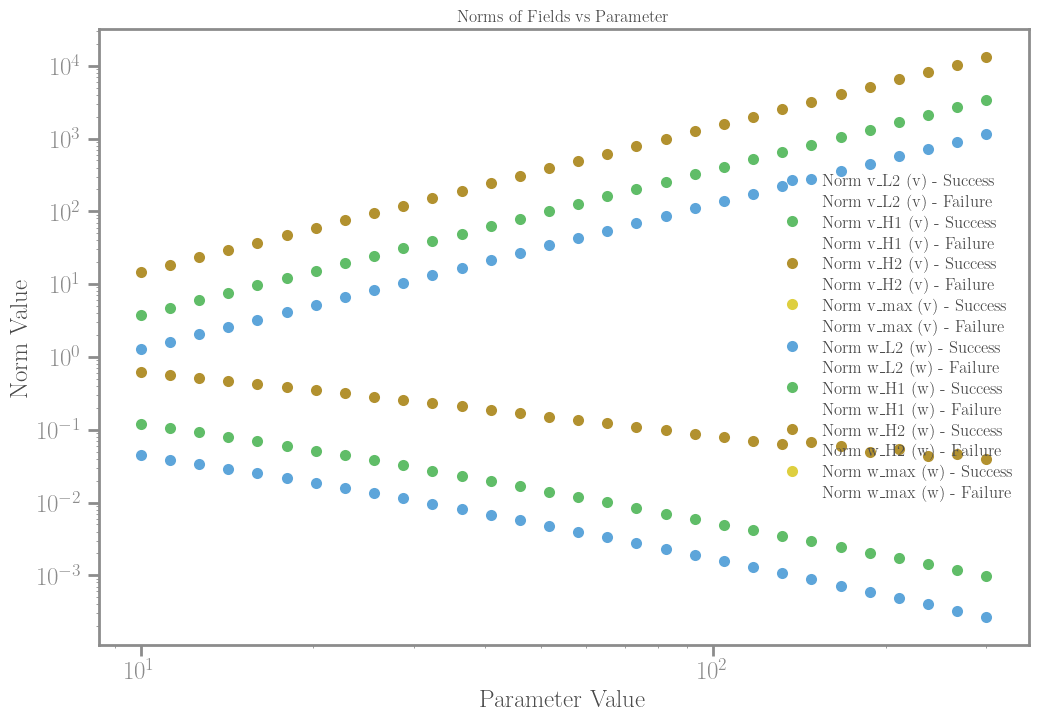

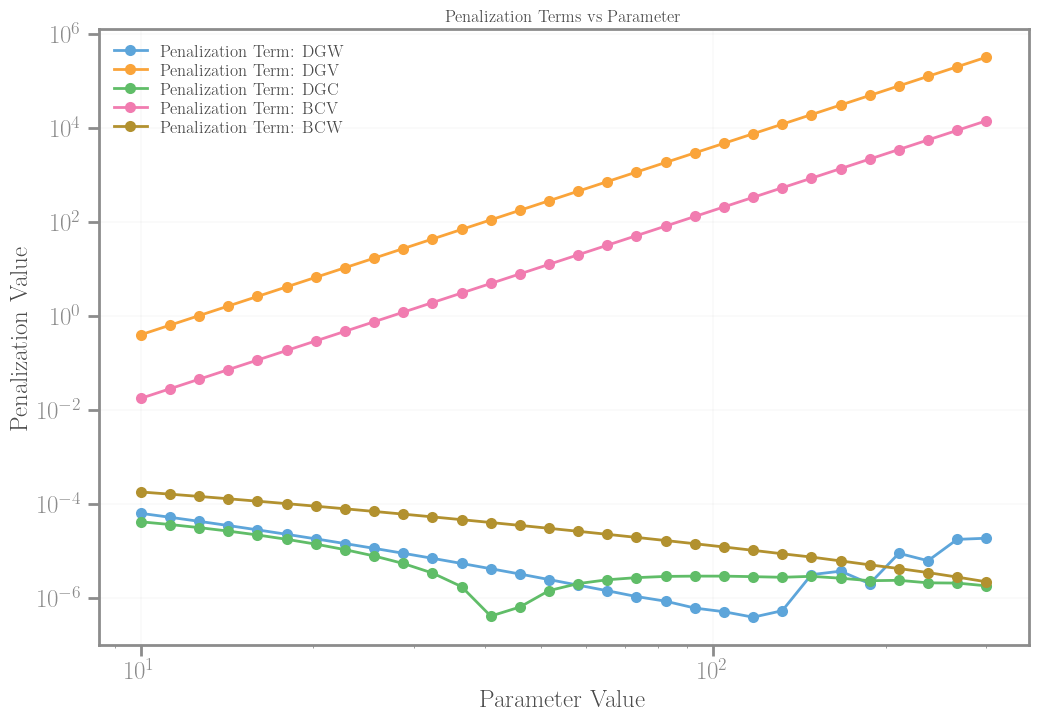

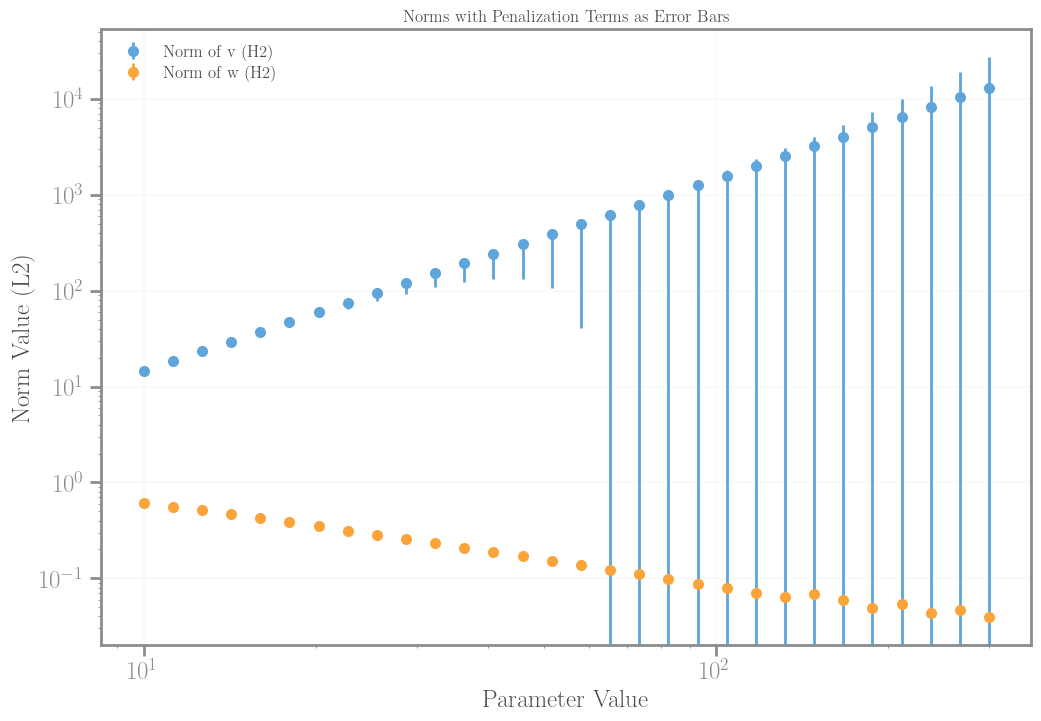

In [ ]:


# ### Residual Analysis
# Plot the residual norm
plot_residuals(experimental_data)

# ### Solver Statistics
# Plot solver statistics
plot_solver_stats(experimental_data)

# ### Norms Analysis
# Plot the norms (L2, H1, H2) for fields v and w
plot_norms(experimental_data)
_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["v_H2"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = 8, x00=10, y10 = .10, y00=10, scale_factor=1, color='C2')

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["w_L2"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = 10, x00=2, y10 = .001, y00=1.1, scale_factor=10, color='C3', spin='top_right')

# ### Penalization Terms Analysis
# Plot the penalization terms
plot_penalization(experimental_data)

# ### Norms with Penalization Terms
plot_norms_with_penalization(experimental_data)

/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_85807/845257478.py:36: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_85807/845257478.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_85807/845257478.py:42: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  #

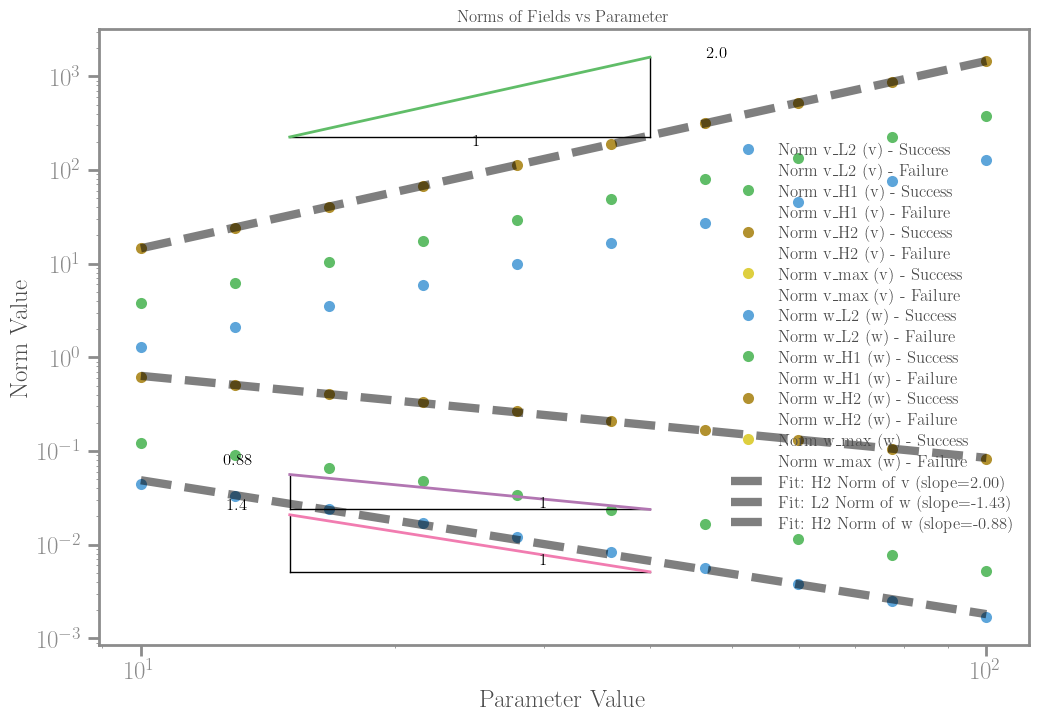

In [ ]:
fig, axs = plot_norms(experimental_data)

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["v_H2"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = 8, x00=10, y10 = .10, y00=10, scale_factor=1, color='C2')
axs.plot(experimental_data["param_value"], _fit, label=f"Fit: H2 Norm of v (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["w_L2"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = 10, x00=2, y10 = .001, y00=1.1, scale_factor=1, color='C3', spin='top_right')
axs.plot(experimental_data["param_value"], _fit, label=f"Fit: L2 Norm of w (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["w_H2"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = 10, x00=2, y10 = .001, y00=1.1, scale_factor=.6, color='C5', spin='top_right')
axs.plot(experimental_data["param_value"], _fit, label=f"Fit: H2 Norm of w (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)


axs.legend()
# axs.set_xlim(1e-1, 1e4)
# axs.set_ylim(1e-4, 1e6)


In [ ]:
!ls

__pycache__
_preposterous.py
adimensions.ipynb
analytic_fvk.ipynb
disclinations.log
experiment_00
experiment_01
experiment_02
experiment_Parametric_Relative_Work
experiment_Parametric_Relative_Work_constant_transverse
experiment_parametric_dipole
experiment_parametric_transverse
monopole.py
output
overview_experiments.md
parameters.yml
parametric_penalisation
postprocess.ipynb
postprocess.py


Loading data from: experiment_Parametric_Relative_Work_constant_transverse/output/969e82/experimental_data.pkl
Loading data from: experiment_Parametric_Relative_Work_constant_transverse/output/9be536/experimental_data.pkl
Loading data from: experiment_Parametric_Relative_Work_constant_transverse/output/cd2171/experimental_data.pkl
Loading data from: experiment_Parametric_Relative_Work_constant_transverse/output/5af391/experimental_data.pkl
Loading data from: experiment_Parametric_Relative_Work_constant_transverse/output/4e8ede/experimental_data.pkl
Loading data from: experiment_Parametric_Relative_Work_constant_transverse/output/0869de/experimental_data.pkl
Loading data from: experiment_Parametric_Relative_Work_constant_transverse/output/00da40/experimental_data.pkl


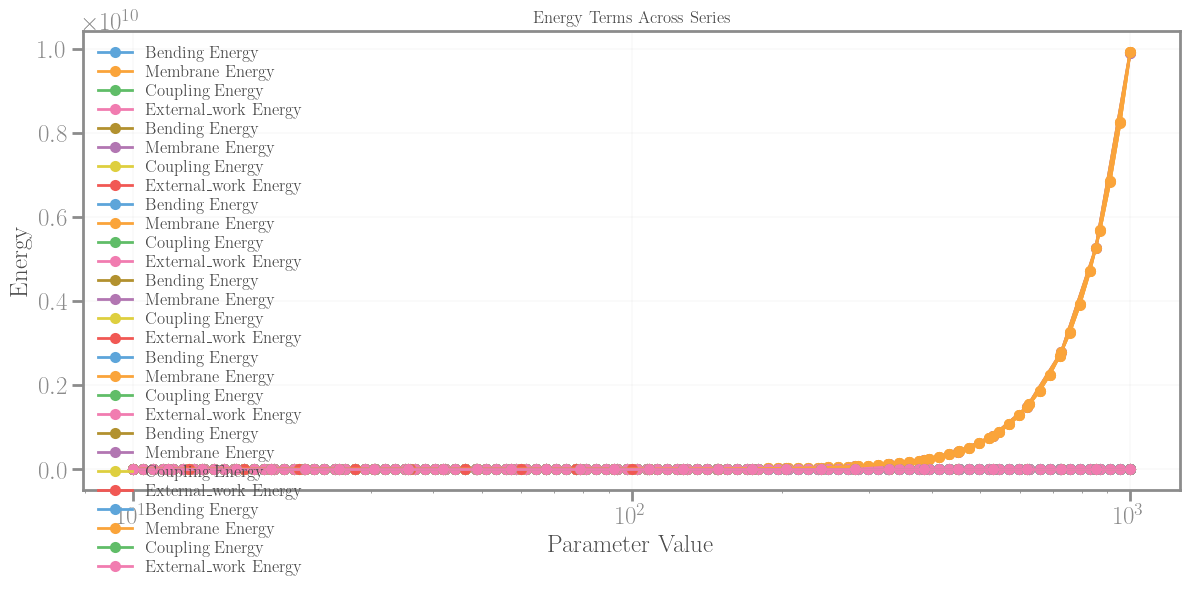

In [ ]:
# def plot_all_series_energy_terms(folder_path, energy_terms=["bending", "membrane", "coupling", "external_work"]):
"""
Plot energy terms for all series in a given folder.

Args:
    folder_path (str): Path to the folder containing series subfolders.
    energy_terms (list): List of energy terms to plot (default: ["bending", "membrane", "coupling", "external_work"]).
"""

folder_path = "experiment_Parametric_Relative_Work_constant_transverse/output"  # Update with your folder path

# Initialize a figure and axis
fig, axs = plt.subplots(figsize=(12, 6))

# Iterate through all subfolders in the folder
for series_name in os.listdir(folder_path):
    series_path = os.path.join(folder_path, series_name)
    if os.path.isdir(series_path):  # Ensure it's a directory
        # print(series_path)

        data_file = os.path.join(series_path, "experimental_data.pkl")
        if os.path.isfile(data_file):  # Ensure the data file exists
            print(f"Loading data from: {data_file}")
        #     # Load the data
            experimental_data = pd.read_pickle(data_file)
            plot_energy_terms(experimental_data, fig=fig, axs=axs, energy_terms=["bending", "membrane", "coupling", "external_work"])
        #     # Plot each energy term for this series
        #     for energy_term in energy_terms:
        #         if energy_term in experimental_data.columns:
        #             ax.plot(
        #                 experimental_data["param_value"],
        #                 experimental_data[energy_term],
        #                 label=f"{energy_term} ({series_name})",
        #                 marker="o",
        #             )

# Customize the plot
axs.set_title("Energy Terms Across Series")
axs.set_xlabel("Parameter Value")
axs.set_ylabel("Energy")
axs.set_yscale("linear")
axs.set_xscale("log")
axs.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

## Parametric, varying load, monopole

In [ ]:
!ls

__pycache__
_preposterous.py
adimensions.ipynb
analytic_fvk.ipynb
disclinations.log
experiment_00
experiment_01
experiment_02
experiment_Parametric_Relative_Work
experiment_Parametric_Relative_Work_constant_transverse
experiment_Parametric_Relative_work_constant_thickness
experiment_parametric_dipole
experiment_parametric_transverse
monopole.py
output
overview_experiments.md
parameters.yml
parametric_penalisation
postprocess.ipynb
postprocess.py


In [ ]:
def exact_energy_monopole(parameters, h, adimensional=True):
    # it should depend on the signs as well

    energy_scale = 1
    if adimensional:
        energy_scale = parameters["model"]["E"] * h ** 5 / parameters["geometry"]["radius"] ** 2    
    return (
        1/energy_scale * 
        parameters["model"]["E"]
        * h 
        / (32 * np.pi)
        * parameters["geometry"]["radius"] ** 2
    )

In [ ]:
exact_energy_monopole(parameters, 0.01)

994718.3943243457

In [192]:
data_file = "experiment_Parametric_Relative_work_constant_thickness/output/5f1f1d/experimental_data.pkl"  # Update with your file path
experimental_data = pd.read_pickle(data_file)

experimental_folder = os.path.dirname(data_file)
series = data_file.split("/")[-2]
output_folder = os.path.join(*[s for s in os.path.dirname(data_file).split('/')[0:2]])

with open(os.path.join(experimental_folder, 'parameters.yml')) as f:
    parameters = yaml.load(f, Loader=yaml.FullLoader)

# Display basic information about the dataset
print("Loaded Data Information:")
print(experimental_data.info())

# ## Data Overview
# Show the first few rows of the data for an overview
display(experimental_data.head())


Loaded Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   signature                  10 non-null     object 
 1   param_value                10 non-null     float64
 2   total                      10 non-null     float64
 3   bending                    10 non-null     float64
 4   membrane                   10 non-null     float64
 5   coupling                   10 non-null     float64
 6   external_work              10 non-null     float64
 7   v_L2                       10 non-null     float64
 8   w_L2                       10 non-null     float64
 9   v_H1                       10 non-null     float64
 10  w_H1                       10 non-null     float64
 11  v_H2                       10 non-null     float64
 12  w_H2                       10 non-null     float64
 13  v_max                      1

,signature,param_value,total,bending,membrane,coupling,external_work,v_L2,w_L2,v_H1,...,bcv,bcw,snes_iterations,snes_convergence_reason,snes_final_residual_norm,snes_function_evaluations,ksp_iterations_last,ksp_convergence_reason,ksp_final_residual_norm,ksp_type
0,ecfdde0f0c00a4a76ea57dc83edfa4bf,0.100000,-993393.284248,0.000003,993393.284262,0.000011,0.000027,127.379070,0.000168,376.097962,...,-175.185131,-1.271592e-07,2,3,0.000061,3,1,4,0.0,preonly
1,ef9b20a84ffffd6e8740f3352e0cf05e,0.166810,-993392.741847,0.000008,993392.741886,0.000030,0.000076,127.379032,0.000280,376.097850,...,-175.185043,-3.538289e-07,2,3,0.000169,3,1,4,0.0,preonly
2,31a4d406f70820eda901d06dc9e05d83,0.278256,-993391.232589,0.000022,993391.232695,0.000084,0.000212,127.378926,0.000467,376.097541,...,-175.184799,-9.845579e-07,2,3,0.000471,3,1,4,0.0,preonly
3,58416a4f74e83fbd2c5a57ed0f4f124d,0.464159,-993387.033020,0.000062,993387.033317,0.000234,0.000589,127.378630,0.000780,376.096679,...,-175.184120,-2.739651e-06,2,3,0.001311,3,1,4,0.0,preonly
4,36b3eaae178e70890cc74b4d86cd991f,0.774264,-993375.347728,0.000173,993375.348554,0.000653,0.001639,127.377805,0.001301,376.094281,...,-175.182231,-7.623709e-06,2,3,0.003649,3,1,4,0.0,preonly


/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_85807/845257478.py:42: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_85807/845257478.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)


Saved to experiment_Parametric_Relative_work_constant_thickness/output/5f1f1d_energy_terms


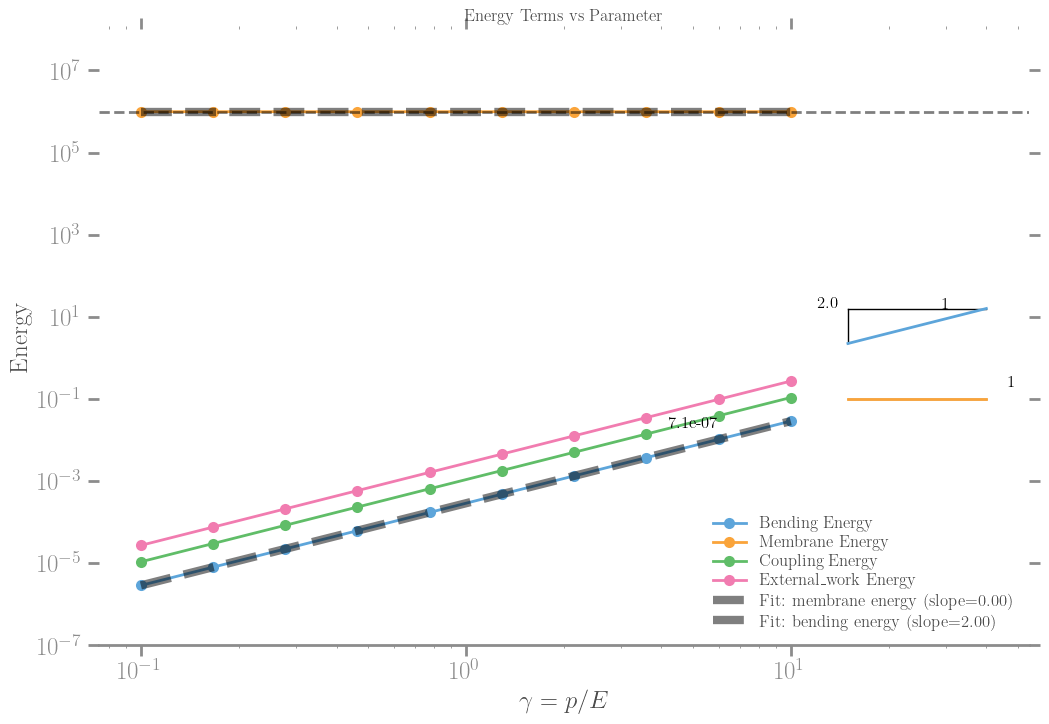

In [193]:
# ## Data Analysis
# ### Energy Analysis
# Plot energy terms
fig, axs = plot_energy_terms(experimental_data)

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["membrane"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = -8, x00=10, y10 = .10, y00=10, scale_factor=.1, color='C1', spin='top_right')
axs.plot(experimental_data["param_value"], _fit, label=f"Fit: membrane energy (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["bending"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = 10, x00=2, y10 = .001, y00=1.1, scale_factor=.01, color='C0', spin='top_right')
axs.plot(experimental_data["param_value"], _fit, label=f"Fit: bending energy (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

axs.legend()
# _slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["w_H2"])
# plot_reference_triangle(axs, _slope, 15, 40, x10 = 10, x00=2, y10 = .001, y00=1.1, scale_factor=.6, color='C5', spin='top_right')
# axs.plot(experimental_data["param_value"], _fit, label=f"Fit: H2 Norm of w (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

# axs.set_xlim(1e1, 1e2)
# axs.axvline(1e2, color='k', linestyle='--', alpha=0.5)
axs.set_ylim(1e-7, 1e8)
visuals.setspines0()
axs.axhline(exact_energy_monopole(parameters, 0.01), color='k', linestyle='--', alpha=0.5)
axs.set_xlabel("$$\\gamma = p/E$$")
fig.savefig(f"{output_folder}/{series}_energy_terms.pdf", bbox_inches='tight')
fig.savefig(f"{output_folder}/{series}_energy_terms.png", bbox_inches='tight')
print(f"Saved to {output_folder}/{series}_energy_terms")


## different penalisation parameter

In [ ]:
data_file = "experiment_Parametric_Relative_Work_constant_transverse/output/5af391/experimental_data.pkl"  # Update with your file path
experimental_data = pd.read_pickle(data_file)

experimental_folder = os.path.dirname(data_file)

with open(os.path.join(experimental_folder, 'parameters.yml')) as f:
    parameters = yaml.load(f, Loader=yaml.FullLoader)

# Display basic information about the dataset
print("Loaded Data Information:")
print(experimental_data.info())

parameters


Loaded Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   signature                  30 non-null     object 
 1   param_value                30 non-null     float64
 2   total                      30 non-null     float64
 3   bending                    30 non-null     float64
 4   membrane                   30 non-null     float64
 5   coupling                   30 non-null     float64
 6   external_work              30 non-null     float64
 7   v_L2                       30 non-null     float64
 8   w_L2                       30 non-null     float64
 9   v_H1                       30 non-null     float64
 10  w_H1                       30 non-null     float64
 11  v_H2                       30 non-null     float64
 12  w_H2                       30 non-null     float64
 13  dgw                        

{'geometry': {'geom_type': 'circle',
  'geometric_dimension': 2,
  'mesh_size': 0.05,
  'radius': 1.0},
 'loading': None,
 'model': {'E': 1,
  'alpha_penalty': 200,
  'higher_regularity': False,
  'model_dimension': 2,
  'model_type': '2D',
  'nu': 0.15,
  'order': 3,
  'β_adim': nan,
  'γ_adim': 1.0},
 'solvers': {'nonlinear': {'ksp': {'ksp_type': 'preonly', 'pc_type': 'lu'},
   'prefix': 'fvk',
   'snes': {'snes_atol': '1e-6',
    'snes_max_it': 200,
    'snes_monitor': '',
    'snes_rtol': '1e-6',
    'snes_stol': '1e-6',
    'snes_type': 'newtonls'}}}}

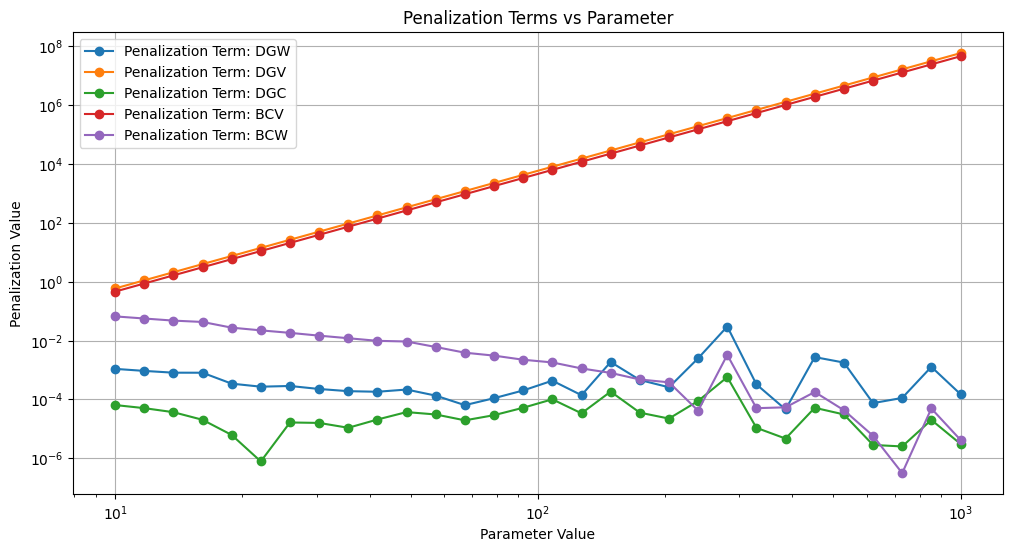

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Penalization Terms vs Parameter'}, xlabel='Parameter Value', ylabel='Penalization Value'>)

In [ ]:
plot_penalization(experimental_data)


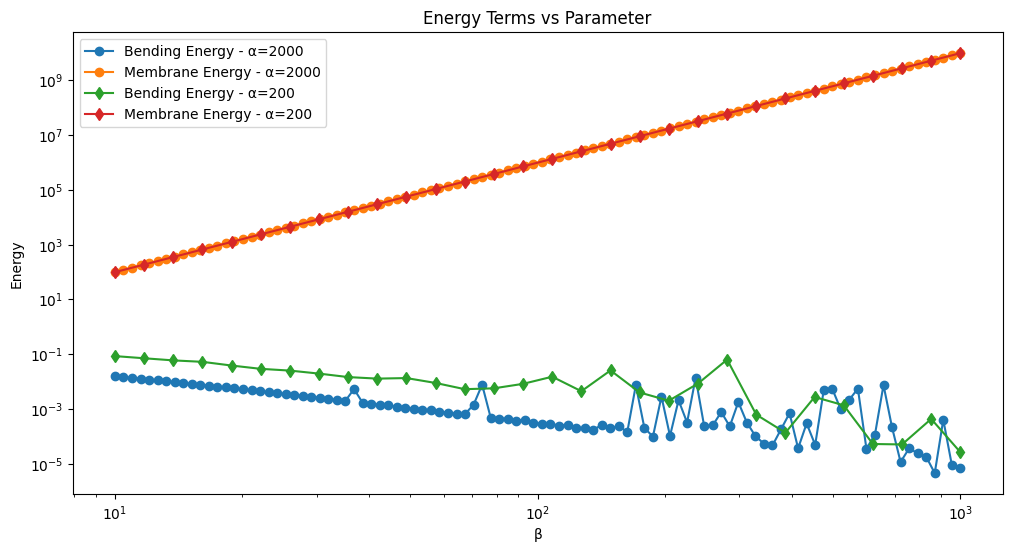

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

data_file = "experiment_Parametric_Relative_Work_constant_transverse/output/cd2171/experimental_data.pkl"  # Update with your file path
experimental_data = pd.read_pickle(data_file)
data = experimental_data

experimental_folder = os.path.dirname(data_file)

with open(os.path.join(experimental_folder, 'parameters.yml')) as f:
    parameters = yaml.load(f, Loader=yaml.FullLoader)

assert parameters["model"]["alpha_penalty"] == 2000

for energy_type in ["bending", "membrane"]:
    plt.plot(
        data["param_value"],
        data[energy_type],
        label=f"{energy_type.capitalize()} Energy - α={parameters['model']['alpha_penalty']}",
        marker="o",
    )
    
# axs.grid(True)
# axs.show()


data_file = "experiment_Parametric_Relative_Work_constant_transverse/output/5af391/experimental_data.pkl"  # Update with your file path
experimental_data = pd.read_pickle(data_file)


data = experimental_data
experimental_folder = os.path.dirname(data_file)

with open(os.path.join(experimental_folder, 'parameters.yml')) as f:
    parameters = yaml.load(f, Loader=yaml.FullLoader)

assert parameters["model"]["alpha_penalty"] == 200

for energy_type in ["bending", "membrane"]:
    plt.plot(
        data["param_value"],
        data[energy_type],
        label=f"{energy_type.capitalize()} Energy - α={parameters['model']['alpha_penalty']}",
        marker="d",
    )

axs.set_title("Energy Terms vs Parameter")
axs.set_xlabel("β")
axs.set_ylabel("Energy")
axs.set_yscale('log')
axs.set_xscale('log')
axs.legend()


## Finer mesh

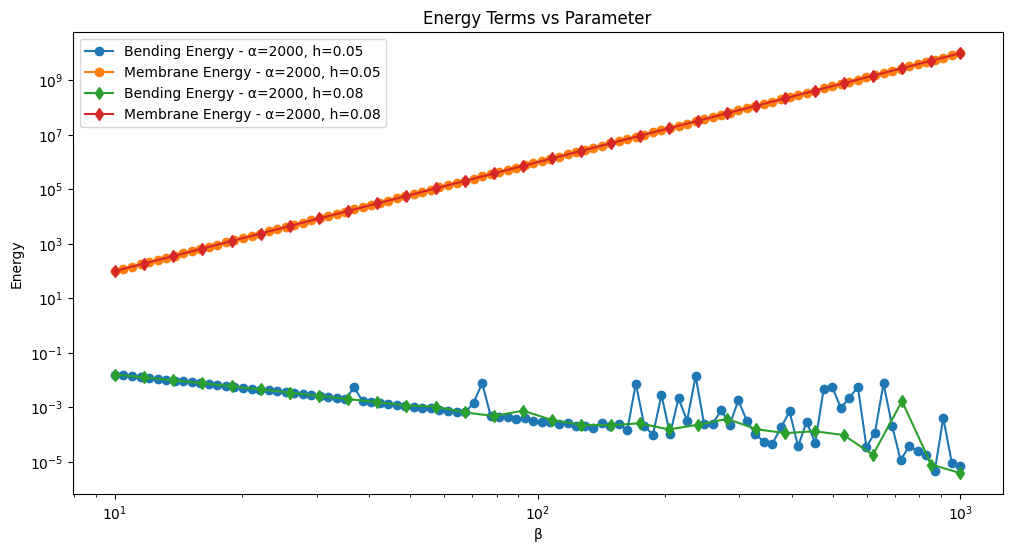

In [ ]:
# 13ca35

fig, axs = plt.subplots(1, 1, figsize=(12, 6))

data_file = "experiment_Parametric_Relative_Work_constant_transverse/output/cd2171/experimental_data.pkl"  # Update with your file path
experimental_data = pd.read_pickle(data_file)
data = experimental_data

experimental_folder = os.path.dirname(data_file)

with open(os.path.join(experimental_folder, 'parameters.yml')) as f:
    parameters = yaml.load(f, Loader=yaml.FullLoader)

assert parameters["model"]["alpha_penalty"] == 2000

for energy_type in ["bending", "membrane"]:
    plt.plot(
        data["param_value"],
        data[energy_type],
        label=f"{energy_type.capitalize()} Energy - α={parameters['model']['alpha_penalty']}, h={parameters['geometry']['mesh_size']}",
        marker="o",
    )
    
# axs.grid(True)
# axs.show()


# data_file = "experiment_Parametric_Relative_Work_constant_transverse/output/5af391/experimental_data.pkl"  # Update with your file path
# assert parameters["model"]["alpha_penalty"] == 200

data_file = "experiment_Parametric_Relative_Work_constant_transverse/output/9be536/experimental_data.pkl"  # Update with your file path
experimental_data = pd.read_pickle(data_file)


data = experimental_data
experimental_folder = os.path.dirname(data_file)

with open(os.path.join(experimental_folder, 'parameters.yml')) as f:
    parameters = yaml.load(f, Loader=yaml.FullLoader)

assert parameters["geometry"]["mesh_size"] == 0.08
for energy_type in ["bending", "membrane"]:
    plt.plot(
        data["param_value"],
        data[energy_type],
        label=f"{energy_type.capitalize()
        } Energy - α={parameters['model']['alpha_penalty']}, h={parameters['geometry']['mesh_size']}",
        marker="d",
    )

axs.set_title("Energy Terms vs Parameter")
axs.set_xlabel("β")
axs.set_ylabel("Energy")
axs.set_yscale('log')
axs.set_xscale('log')
axs.legend()


## Constant transverse load, higher regularity

In [ ]:
!ls experiment_Parametric_Relative_Work_constant_transverse/output/4e8ede

015a53b8963c7273176ee34fde0d78be 85ecedbc7e2f60640a4a0a61b1cee1e7
01d21cc2cb6bc35e7fe71f3986c54fb1 8c90c2e0da7d0abf8069dc66e37e5b9f
082bc59b5ac6b8ee79afdd0832f9dfba 8f09e9ec72495c1b68b2affd9195e43d
0dd1ecf332b1f9b0e4cf25398765c4ff 8f98d1a3ebb192112316dc1118f22238
19affb946f61ea4de525e4745f885e89 90f3c24f5953ecdbd765ab933244ba2b
2607c1ee5915be6d28ddc0a686181b61 929aec5ceed1a6ae4fb4016ca9c4086f
27112e1e6a95da50742079eba65c770f 9d8375f3a94deb1ff0eb3b71b46a25ea
2830a3857d08bae2fe71e82d2757e9b0 9f02e90b187f91d98e0f8c58d1b002d1
2925d67335eaa974392a582f9dcbbaaa 9fc342891f40d756adda154cf4898979
2a93ece0c1b22430c51f83ed468caaba a2ebe79d2f6687ffcc2be2aec134cc16
2e21d81aab3b76e6112a596deccac4b4 a376bc371c7129bc2675f63c625ed401
2fc58ebf5c180315e1b7610f96ac3001 a650d503052b0731e29d7b889d655f97
31f22984dfaabb0325e4ab5117ed9bbc aab6eeb3e551c27827999653dca559fb
343bb61755700cadee6e95c258fae3ab b1b1237d0a24d2c20fa1e8610c0e1d4c
364f1fad35b2578c666b73d40606c8bd b62e6a447d5b83131fc8d64ecc1be348
44ac0062ac

In [ ]:
data_file = "experiment_Parametric_Relative_Work_constant_transverse/output/4e8ede/experimental_data.pkl"  # Update with your file path
experimental_data = pd.read_pickle(data_file)
experimental_data_hr = experimental_data

# load parameters file in data_file directoruy
# parameters_file = "experiment_Parametric_Relative_Work_constant_transverse/output/4e8ede/parameters.yml"

# get folder of data_file

experimental_folder = os.path.dirname(data_file)

with open(os.path.join(experimental_folder, 'parameters.yml')) as f:
    parameters = yaml.load(f, Loader=yaml.FullLoader)


assert parameters["model"]["higher_regularity"] == True

# Display basic information about the dataset
print("Loaded Data Information:")
print(experimental_data.info())

# ## Data Overview
# Show the first few rows of the data for an overview
display(experimental_data.head())


Loaded Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   signature                  100 non-null    object 
 1   param_value                100 non-null    float64
 2   total                      100 non-null    float64
 3   bending                    100 non-null    float64
 4   membrane                   100 non-null    float64
 5   coupling                   100 non-null    float64
 6   external_work              100 non-null    float64
 7   v_L2                       100 non-null    float64
 8   w_L2                       100 non-null    float64
 9   v_H1                       100 non-null    float64
 10  w_H1                       100 non-null    float64
 11  v_H2                       100 non-null    float64
 12  w_H2                       100 non-null    float64
 13  dgw                       

,signature,param_value,total,bending,membrane,coupling,external_work,v_L2,w_L2,v_H1,...,bcv,bcw,snes_iterations,snes_convergence_reason,snes_final_residual_norm,snes_function_evaluations,ksp_iterations_last,ksp_convergence_reason,ksp_final_residual_norm,ksp_type
0,3e2454356ed3f5b0066290b9b7531ea6,10.000000,-99.303548,0.006130,99.326696,0.017018,0.048219,1.269853,0.035986,3.749035,...,-0.047420,-0.000015,3,3,0.000019,4,1,4,0.0,preonly
1,54bce7f3552d3971a849b698aca4cb67,10.476158,-119.613482,0.005379,119.635055,0.016194,0.045129,1.393634,0.033639,4.114481,...,-0.057116,-0.000012,3,3,0.000018,4,1,4,0.0,preonly
2,a1046b5c6db792fe200b910de38bbdcb,10.974988,-144.076632,0.004712,144.096710,0.015366,0.042192,1.529487,0.031409,4.515567,...,-0.068794,-0.000010,3,3,0.000016,4,1,4,0.0,preonly
3,386f59ec212969246ff7155c0b00b98e,11.497570,-173.542371,0.004121,173.561033,0.014541,0.039408,1.678589,0.029296,4.955767,...,-0.082861,-0.000008,3,3,0.000015,4,1,4,0.0,preonly
4,6785b8d008e9983ae662d42dfdc8245e,12.045035,-209.033767,0.003600,209.051093,0.013727,0.036778,1.842230,0.027300,5.438894,...,-0.099804,-0.000007,3,3,0.000014,4,1,4,0.0,preonly


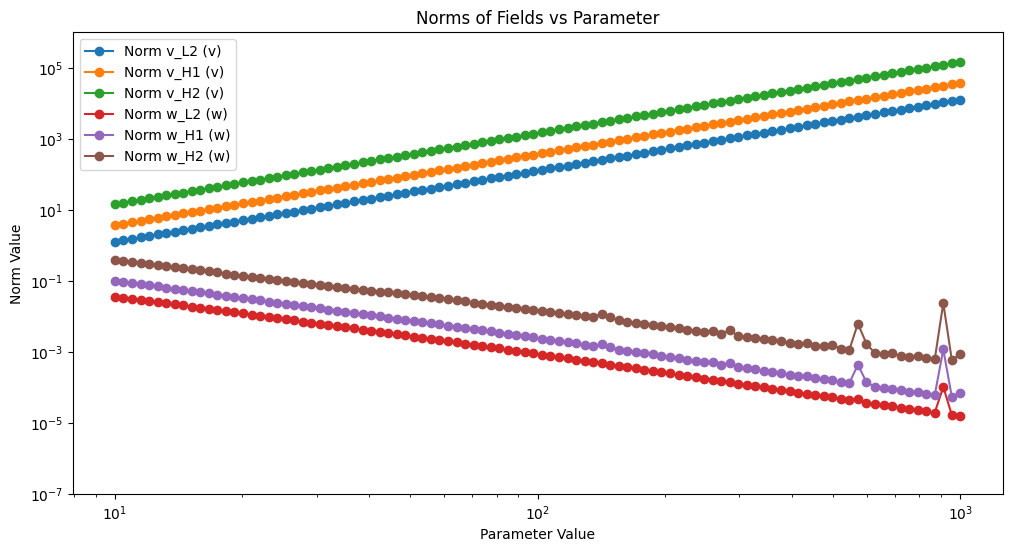

In [ ]:
fig, axs = plot_norms(experimental_data)
# axs.plot(experimental_data["param_value"], _fit, label=f"Fit: H2 Norm of v (slope={_slope:.2f})", linestyle="--", color="C2")
axs.set_ylim(1e-7, 1e6)
axs.legend()

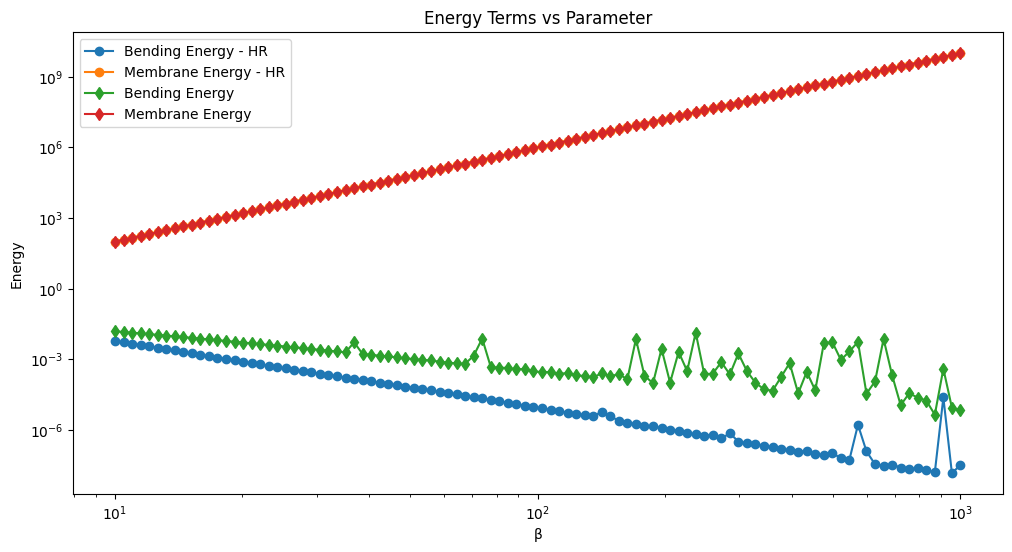

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

data_file = "experiment_Parametric_Relative_Work_constant_transverse/output/4e8ede/experimental_data.pkl"  # Update with your file path
experimental_data = pd.read_pickle(data_file)
data = experimental_data

experimental_folder = os.path.dirname(data_file)

with open(os.path.join(experimental_folder, 'parameters.yml')) as f:
    parameters = yaml.load(f, Loader=yaml.FullLoader)

assert parameters["model"]["higher_regularity"] == True

for energy_type in ["bending", "membrane"]:
    plt.plot(
        data["param_value"],
        data[energy_type],
        label=f"{energy_type.capitalize()} Energy - HR",
        marker="o",
    )
    
# axs.grid(True)
# axs.show()


data_file = "experiment_Parametric_Relative_Work_constant_transverse/output/cd2171/experimental_data.pkl"  # Update with your file path
experimental_data = pd.read_pickle(data_file)


data = experimental_data
experimental_folder = os.path.dirname(data_file)

with open(os.path.join(experimental_folder, 'parameters.yml')) as f:
    parameters = yaml.load(f, Loader=yaml.FullLoader)

assert parameters["model"]["higher_regularity"] == False

for energy_type in ["bending", "membrane"]:
    plt.plot(
        data["param_value"],
        data[energy_type],
        label=f"{energy_type.capitalize()} Energy",
        marker="d",
    )

axs.set_title("Energy Terms vs Parameter")
axs.set_xlabel("β")
axs.set_ylabel("Energy")
axs.set_yscale('log')
axs.set_xscale('log')
axs.legend()


## Varying penalisation, dipole test


In [ ]:
!ls parametric_penalisation/output/

ddac81
mesh-77c77d390287d4f5cd97fa884885a293.h5
mesh-77c77d390287d4f5cd97fa884885a293.xdmf
mesh-bba24ccdb56d042e3369d06514fda4cc.h5
mesh-bba24ccdb56d042e3369d06514fda4cc.xdmf


In [ ]:
data_file = "parametric_penalisation/output/ddac81/experimental_data.pkl"  # Update with your file path
experimental_data = pd.read_pickle(data_file)

experimental_folder = os.path.dirname(data_file)

with open(os.path.join(experimental_folder, 'parameters.yaml')) as f:
    parameters = yaml.load(f, Loader=yaml.FullLoader)

# assert parameters["model"]["higher_regularity"] == True

# Display basic information about the dataset
print("Loaded Data Information:")
print(experimental_data.info())

# ## Data Overview
# Show the first few rows of the data for an overview
display(experimental_data.head())


Loaded Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   signature                  30 non-null     object 
 1   param_value                30 non-null     float64
 2   total                      30 non-null     float64
 3   bending                    30 non-null     float64
 4   membrane                   30 non-null     float64
 5   coupling                   30 non-null     float64
 6   v_L2                       30 non-null     float64
 7   w_L2                       30 non-null     float64
 8   v_H1                       30 non-null     float64
 9   w_H1                       30 non-null     float64
 10  v_H2                       30 non-null     float64
 11  w_H2                       30 non-null     float64
 12  v_max                      30 non-null     float64
 13  w_max                      

,signature,param_value,total,bending,membrane,coupling,v_L2,w_L2,v_H1,w_H1,...,bcv,bcw,snes_iterations,snes_convergence_reason,snes_final_residual_norm,snes_function_evaluations,ksp_iterations_last,ksp_convergence_reason,ksp_final_residual_norm,ksp_type
0,e4919482a3d7a2422df6e715ea763674,10.000000,-80.630865,0.0,80.630865,0.0,0.442107,0.0,2.113823,0.0,...,21.240573,0.0,1,2,9.215678e-09,2,1,4,0.0,preonly
1,e5b69e254b49b8bc760784f128d1e481,11.721023,-119.057553,0.0,119.057553,0.0,0.418984,0.0,2.040949,0.0,...,61.817978,0.0,1,2,1.041940e-08,2,1,4,0.0,preonly
2,71ed73a533e196fa782f2208d8c1c50c,13.738238,-33890.719331,0.0,33890.719331,0.0,1.256787,0.0,6.850232,0.0,...,34970.768378,0.0,1,2,3.604748e-08,2,1,4,0.0,preonly
3,360e8898a5a6a80ccef45d439b4a75b3,16.102620,-1811.575649,0.0,1811.575649,0.0,0.533997,0.0,2.494571,0.0,...,1829.177490,0.0,1,2,1.696870e-08,2,1,4,0.0,preonly
4,a13ad28ce4aa05f6e0b472e591f1144f,18.873918,-72.985968,0.0,72.985968,0.0,0.485826,0.0,2.188912,0.0,...,10.100171,0.0,1,2,1.607360e-08,2,1,4,0.0,preonly


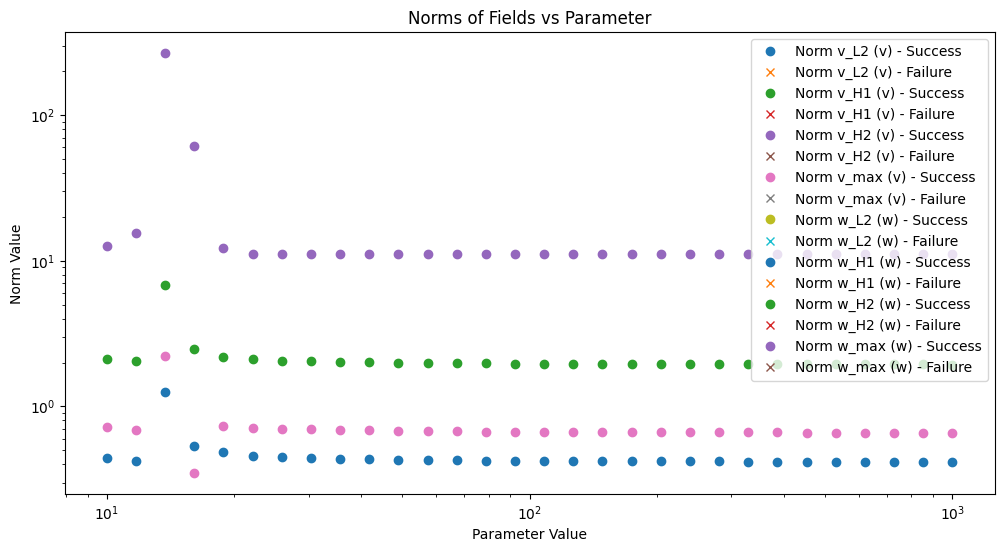

In [ ]:
fig, axs = plot_norms(experimental_data)


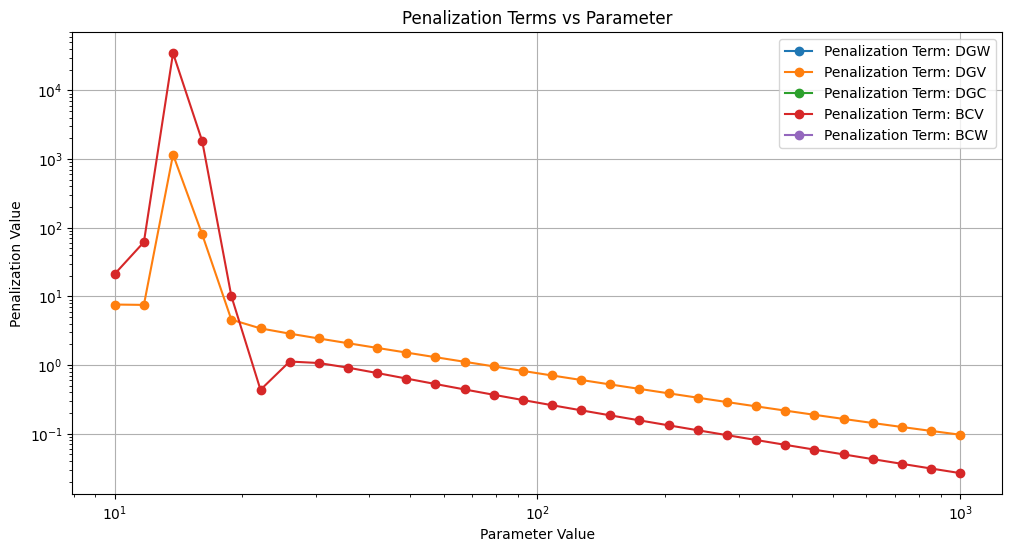

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Penalization Terms vs Parameter'}, xlabel='Parameter Value', ylabel='Penalization Value'>)

In [ ]:
plot_penalization(experimental_data)


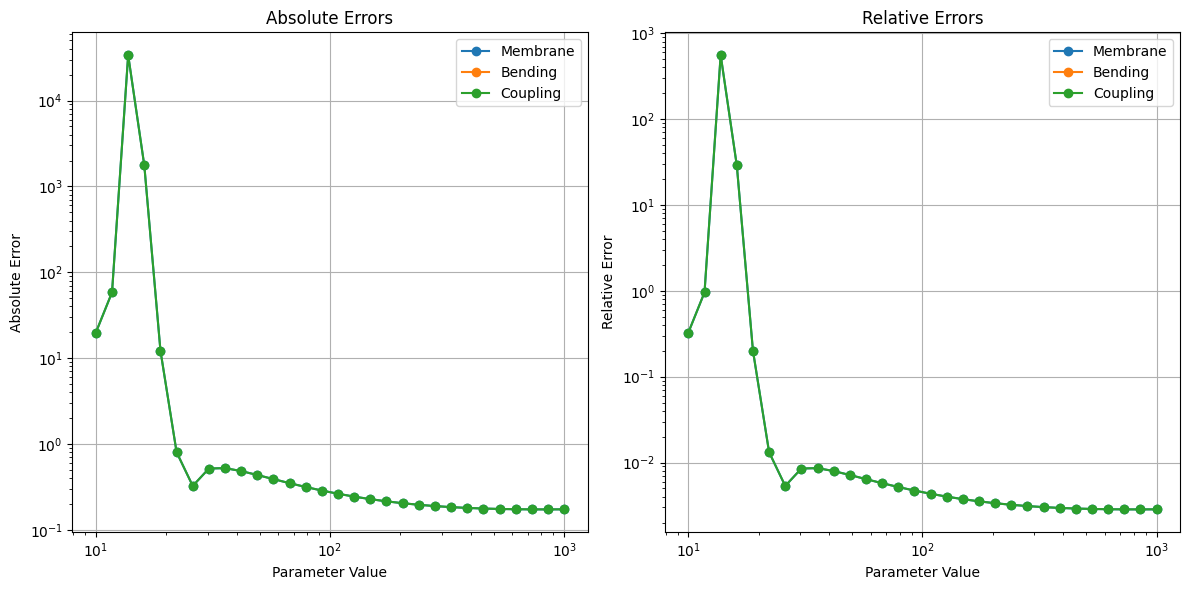

In [ ]:
data = experimental_data

plt.figure(figsize=(12, 6))

# Absolute errors
plt.subplot(1, 2, 1)
plt.plot(data[x_column], data["abs_error_membrane"], label="Membrane", marker="o")
plt.plot(data[x_column], data["abs_error_bending"], label="Bending", marker="o")
plt.plot(data[x_column], data["abs_error_coupling"], label="Coupling", marker="o")
plt.title("Absolute Errors")
plt.xlabel("Parameter Value")
plt.ylabel("Absolute Error")
plt.xscale("log")  # Log scale for better visibility
plt.yscale("log")
plt.legend()
plt.grid(True)

# Relative errors
plt.subplot(1, 2, 2)
plt.plot(data[x_column], data["rel_error_membrane"], label="Membrane", marker="o")
plt.plot(data[x_column], data["rel_error_bending"], label="Bending", marker="o")
plt.plot(data[x_column], data["rel_error_coupling"], label="Coupling", marker="o")
plt.title("Relative Errors")
plt.xlabel("Parameter Value")
plt.ylabel("Relative Error")
plt.xscale("log")  # Log scale for better visibility
plt.yscale("log")
plt.legend()
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

### Compression

In [ ]:
data_file = "experiment_Parametric_Relative_Work_constant_transverse/output/969e82/experimental_data.pkl"  # Update with your file path

# 00da40, 969e82
experimental_data = pd.read_pickle(data_file)
experimental_data_hr = experimental_data

# load parameters file in data_file directoruy
# parameters_file = "experiment_Parametric_Relative_Work_constant_transverse/output/4e8ede/parameters.yml"

# get folder of data_file

experimental_folder = os.path.dirname(data_file)

with open(os.path.join(experimental_folder, 'parameters.yml')) as f:
    parameters = yaml.load(f, Loader=yaml.FullLoader)


# Display basic information about the dataset
print("Loaded Data Information:")
print(experimental_data.info())

# ## Data Overview
# Show the first few rows of the data for an overview
display(experimental_data.head())


Loaded Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   signature                  100 non-null    object 
 1   param_value                100 non-null    float64
 2   total                      100 non-null    float64
 3   bending                    100 non-null    float64
 4   membrane                   100 non-null    float64
 5   coupling                   100 non-null    float64
 6   external_work              100 non-null    float64
 7   v_L2                       100 non-null    float64
 8   w_L2                       100 non-null    float64
 9   v_H1                       100 non-null    float64
 10  w_H1                       100 non-null    float64
 11  v_H2                       100 non-null    float64
 12  w_H2                       100 non-null    float64
 13  v_max                     

,signature,param_value,total,bending,membrane,coupling,external_work,v_L2,w_L2,v_H1,...,bcv,bcw,snes_iterations,snes_convergence_reason,snes_final_residual_norm,snes_function_evaluations,ksp_iterations_last,ksp_convergence_reason,ksp_final_residual_norm,ksp_type
0,94ce8218e629fdb2eb14e68e8a0242ed,10.000000,-98.946200,0.216023,98.936144,-0.226079,-0.026394,1.274443,0.041621,3.761011,...,-0.302344,-0.003307,3,3,0.000007,4,1,4,0.0,preonly
1,aa8aa93a8fd572860f3e79a81042c0e4,10.476158,-119.184396,0.256921,119.198704,-0.242614,0.015993,1.398876,0.031615,4.128247,...,-0.364210,-0.006618,3,3,0.000025,4,1,4,0.0,preonly
2,f68d26eca09a0caf779c9505c834bf8d,10.974988,-143.396243,0.471347,143.445653,-0.421936,0.073023,1.534682,0.054876,4.528965,...,-0.438399,-0.013629,3,3,0.000029,4,1,4,0.0,preonly
3,c6c130d89ce84e070f277a1406ad6f35,11.497570,-173.576276,3.567436,173.751595,-3.392117,0.262310,1.688162,0.185487,4.983947,...,-0.528247,-0.068365,1,-6,0.201589,16,1,4,0.0,preonly
4,98242bd5cc63503e415f006d7647fc11,12.045035,-210.314583,9.309643,210.031286,-9.592940,-0.581700,1.858543,0.409273,5.481882,...,-0.644231,-0.105663,1,-6,0.221225,16,1,4,0.0,preonly


/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_87377/2772413595.py:44: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_87377/2772413595.py:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)


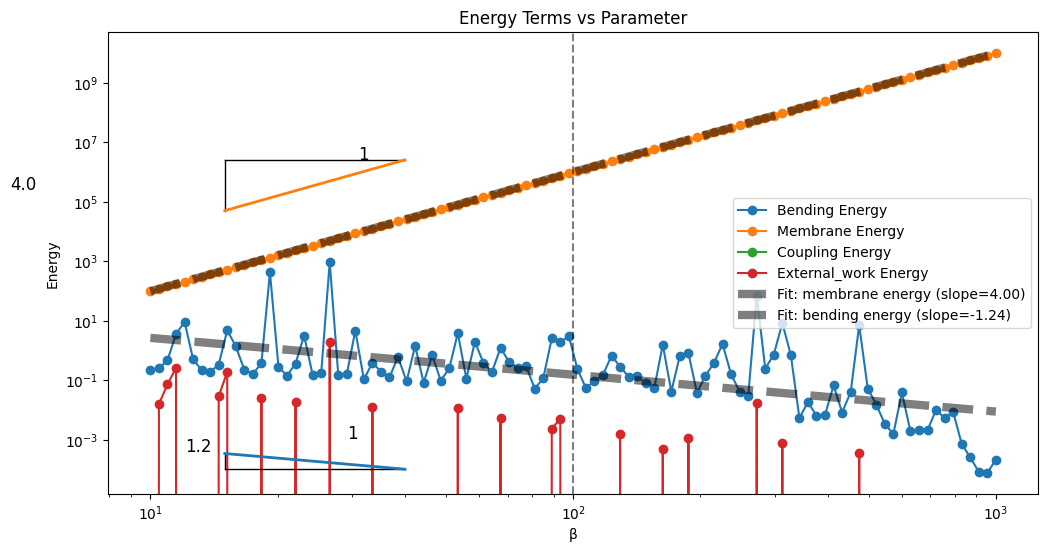

In [ ]:
# ## Data Analysis
# ### Energy Analysis
# Plot energy terms
fig, axs = plot_energy_terms(experimental_data)

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["membrane"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = 8, x00=10, y10 = .10, y00=10, scale_factor=1, color='C1', spin='top_right')
axs.plot(experimental_data["param_value"], _fit, label=f"Fit: membrane energy (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["bending"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = 10, x00=2, y10 = .001, y00=1.1, scale_factor=.01, color='C0', spin='top_right')
axs.plot(experimental_data["param_value"], _fit, label=f"Fit: bending energy (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

axs.legend()
# _slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["w_H2"])
# plot_reference_triangle(axs, _slope, 15, 40, x10 = 10, x00=2, y10 = .001, y00=1.1, scale_factor=.6, color='C5', spin='top_right')
# axs.plot(experimental_data["param_value"], _fit, label=f"Fit: H2 Norm of w (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

# axs.set_xlim(1e1, 1e2)
axs.axvline(1e2, color='k', linestyle='--', alpha=0.5)
# axs.set_ylim(1e-5, 1e6)

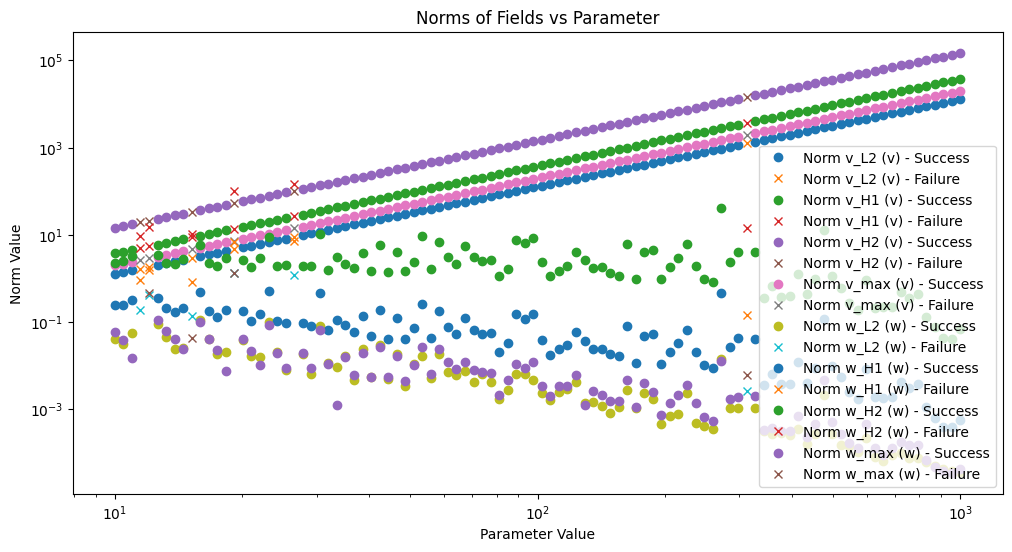

In [ ]:
fig, axs = plot_norms(experimental_data)


In [ ]:
experimental_data.columns

Index(['signature', 'param_value', 'total', 'bending', 'membrane', 'coupling',
       'external_work', 'v_L2', 'w_L2', 'v_H1', 'w_H1', 'v_H2', 'w_H2',
       'v_max', 'w_max', 'dgw', 'dgv', 'dgc', 'bcv', 'bcw', 'snes_iterations',
       'snes_convergence_reason', 'snes_final_residual_norm',
       'snes_function_evaluations', 'ksp_iterations_last',
       'ksp_convergence_reason', 'ksp_final_residual_norm', 'ksp_type'],
      dtype='object')

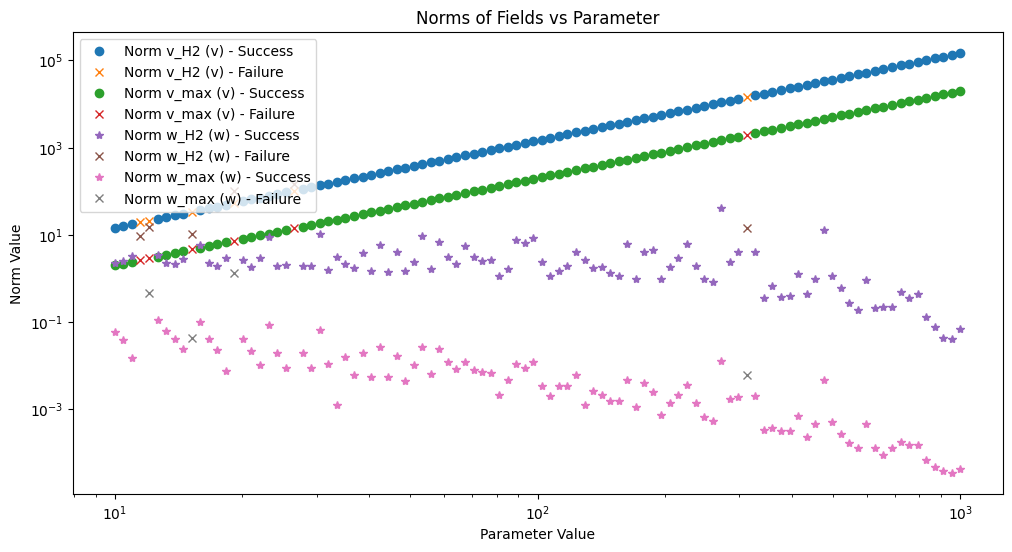

In [ ]:
data = experimental_data
converged_indices = data["snes_convergence_reason"] >= 0
non_converged_indices = data["snes_convergence_reason"] < 0

# Define marker styles
success_marker = "o"  # Circle for successful convergence
failure_marker = "x"  # Cross for non-convergence

fig, axs = plt.subplots(1, 1, figsize=(12, 6))

# Plot norms for v
for norm_type in ["v_H2", "v_max"]:
    # Plot successfully converged points
    axs.plot(
        data[x_column][converged_indices],
        data[norm_type][converged_indices],
        label=f"Norm {norm_type} (v) - Success",
        marker=success_marker,
        linestyle="",
    )
    # Plot non-converged points
    axs.plot(
        data[x_column][non_converged_indices],
        data[norm_type][non_converged_indices],
        label=f"Norm {norm_type} (v) - Failure",
        marker=failure_marker,
        linestyle="",
    )
    
# axs.twinx()
success_marker = "*"  # Circle for successful convergence

# Plot norms for w
for norm_type in ["w_H2", "w_max"]:
    # Plot successfully converged points
    axs.plot(
        data[x_column][converged_indices],
        data[norm_type][converged_indices],
        label=f"Norm {norm_type} (w) - Success",
        marker=success_marker,
        linestyle="",
    )
    # Plot non-converged points
    axs.plot(
        data[x_column][non_converged_indices],
        data[norm_type][non_converged_indices],
        label=f"Norm {norm_type} (w) - Failure",
        marker=failure_marker,
        linestyle="",
    )

axs.set_title("Norms of Fields vs Parameter")
axs.set_xlabel("Parameter Value")
axs.set_ylabel("Norm Value")
axs.set_yscale("log")
axs.set_xscale("log")
axs.legend()
# fig.grid(True)

## Verification, dipole parametric

In [194]:
!ls experiment_parametric_dipole/output/

4a96c1
4a96c1_energy_terms.pdf
4a96c1_error_terms.pdf
mesh-4c770d2b69133c4ffc50bb254fe63a5a.h5
mesh-4c770d2b69133c4ffc50bb254fe63a5a.xdmf
mesh-7106fe9d81ba5cf491d2283d6d2e0a28.h5
mesh-7106fe9d81ba5cf491d2283d6d2e0a28.xdmf


In [199]:
data_file = "experiment_parametric_dipole/output/4a96c1/experimental_data.pkl"  # Update with your file path
experimental_data = pd.read_pickle(data_file)
series = data_file.split("/")[-2]
output_folder = os.path.join(*[s for s in os.path.dirname(data_file).split('/')[0:2]])

experimental_folder = os.path.dirname(data_file)

with open(os.path.join(experimental_folder, 'parameters.yaml')) as f:
    parameters = yaml.load(f, Loader=yaml.FullLoader)

# assert parameters["model"]["higher_regularity"] == True

# Display basic information about the dataset
print("Loaded Data Information:")
print(experimental_data.info())

# ## Data Overview
# Show the first few rows of the data for an overview
display(experimental_data.head())


Loaded Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   signature                  3 non-null      object 
 1   param_value                3 non-null      float64
 2   total                      3 non-null      float64
 3   bending                    3 non-null      float64
 4   membrane                   3 non-null      float64
 5   coupling                   3 non-null      float64
 6   external_work              3 non-null      float64
 7   v_L2                       3 non-null      float64
 8   w_L2                       3 non-null      float64
 9   v_H1                       3 non-null      float64
 10  w_H1                       3 non-null      float64
 11  v_H2                       3 non-null      float64
 12  w_H2                       3 non-null      float64
 13  v_max                      3 

,signature,param_value,total,bending,membrane,coupling,external_work,v_L2,w_L2,v_H1,...,bcv,bcw,snes_iterations,snes_convergence_reason,snes_final_residual_norm,snes_function_evaluations,ksp_iterations_last,ksp_convergence_reason,ksp_final_residual_norm,ksp_type
0,a33f9515b198a07caa4d27cc0b7b367c,10.000000,-6.060708e+01,0.0,6.060708e+01,0.0,0.0,0.416165,0.0,1.936922,...,-0.000829,0.0,1,3,0.000001,2,1,4,0.0,preonly
1,859a91eba1d9a6d4528f930eb0488235,54.772256,-5.454637e+04,0.0,5.454637e+04,0.0,0.0,12.484939,0.0,58.107651,...,-0.746184,0.0,1,3,0.000034,2,1,4,0.0,preonly
2,c4938358be7ef51ee1d3d16fb120525f,300.000000,-4.909173e+07,0.0,4.909173e+07,0.0,0.0,374.548182,0.0,1743.229536,...,-671.565622,0.0,1,3,0.001013,2,1,4,0.0,preonly


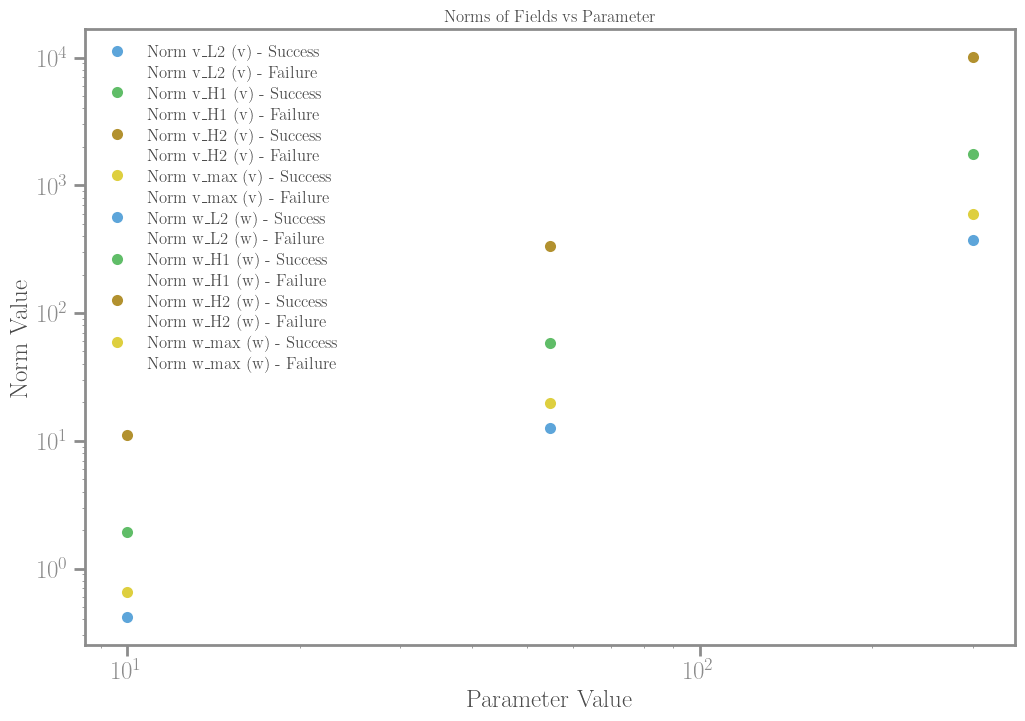

In [200]:
fig, axs = plot_norms(experimental_data)


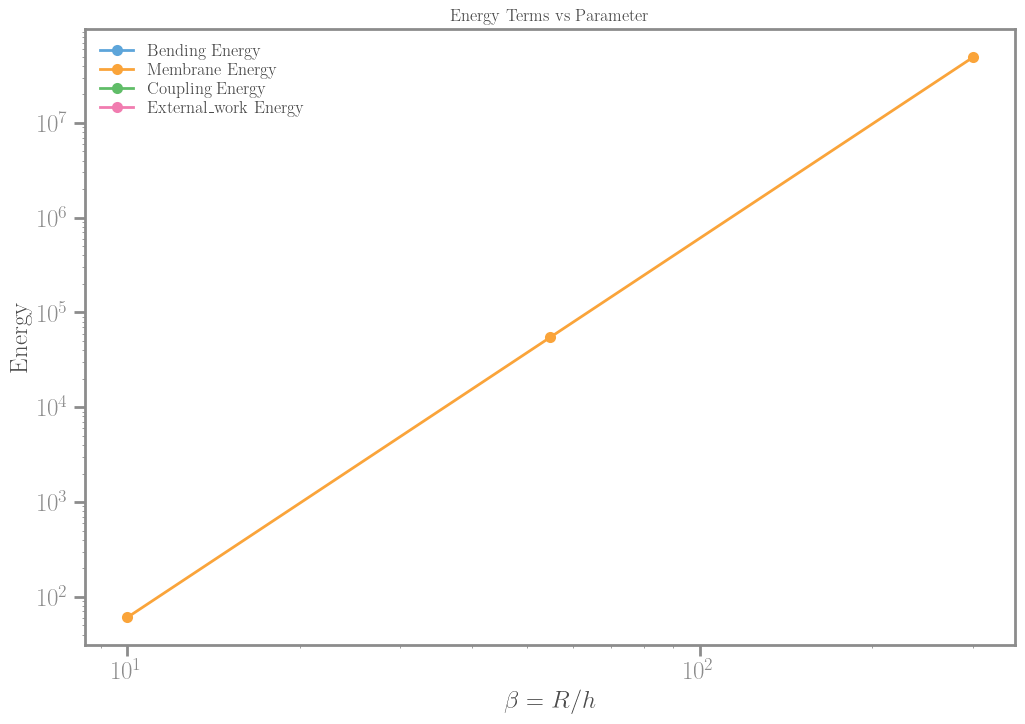

In [201]:
fig, axs = plot_energy_terms(experimental_data)

In [202]:
experimental_data

,signature,param_value,total,bending,membrane,coupling,external_work,v_L2,w_L2,v_H1,...,bcv,bcw,snes_iterations,snes_convergence_reason,snes_final_residual_norm,snes_function_evaluations,ksp_iterations_last,ksp_convergence_reason,ksp_final_residual_norm,ksp_type
0,a33f9515b198a07caa4d27cc0b7b367c,10.000000,-6.060708e+01,0.0,6.060708e+01,0.0,0.0,0.416165,0.0,1.936922,...,-0.000829,0.0,1,3,0.000001,2,1,4,0.0,preonly
1,859a91eba1d9a6d4528f930eb0488235,54.772256,-5.454637e+04,0.0,5.454637e+04,0.0,0.0,12.484939,0.0,58.107651,...,-0.746184,0.0,1,3,0.000034,2,1,4,0.0,preonly
2,c4938358be7ef51ee1d3d16fb120525f,300.000000,-4.909173e+07,0.0,4.909173e+07,0.0,0.0,374.548182,0.0,1743.229536,...,-671.565622,0.0,1,3,0.001013,2,1,4,0.0,preonly


In [ ]:
exact_energy_dipole(parameters, .01)

608297.4786279852

/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_85807/845257478.py:42: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_85807/845257478.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([x0, x1], [y0, y1], 'k-', lw=2, ls=linestyle, c=color)  # Hypotenuse (reference line)


Saved to experiment_parametric_dipole/output/4a96c1_energy_terms


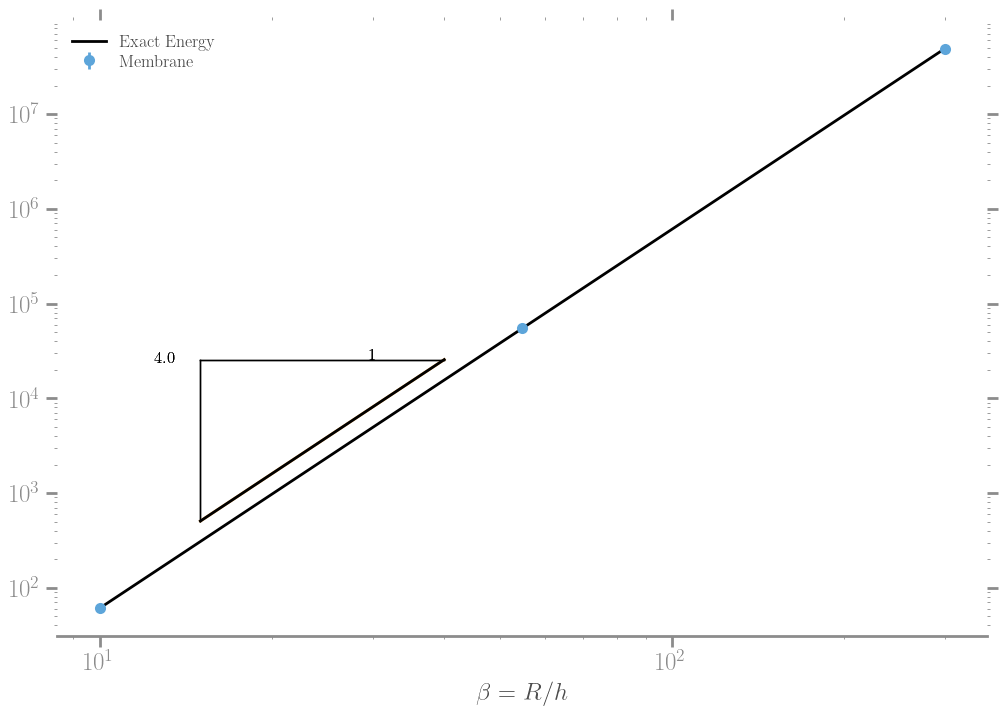

In [206]:
# fig, axs = plot_norms_with_penalization(experimental_data)
# fig, axs = plot_energy_terms(experimental_data)
fig, axs = plt.subplots(1, 1, figsize=(12, 8))

_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], experimental_data["membrane"])
plot_reference_triangle(axs, _slope, 15, 40, x10 = 10, x00=2, y10 = .001, y00=1.1, scale_factor=.01, color='C1', spin='top_right')
# axs.plot(experimental_data["param_value"], _fit, label=f"Fit: membrane energy (slope={_slope:.2f})", linestyle="--", color="k", lw=6, alpha=0.5)

_exact_energy = [exact_energy_dipole(parameters, h, adimensional=True) for h in 1/experimental_data["param_value"]]
_slope, _intercept, _fit = fit_loglog(experimental_data["param_value"], _exact_energy)
axs.plot(experimental_data["param_value"], _exact_energy, label="Exact Energy", c='k')
plot_reference_triangle(axs, _slope, 15, 40, x10 = 10, x00=2, y10 = .001, y00=1.1, scale_factor=.01, color='k', spin='top_right')


data = experimental_data
# Penalization terms for bulk and boundary
v_bulk_penalization = data["dgv"].abs()
v_boundary_penalization = data["bcv"].abs()

axs.errorbar(
    experimental_data["param_value"],
    experimental_data["membrane"],
    # yerr=[1000*v_bulk_penalization, 1000*v_boundary_penalization],
    yerr=1*v_bulk_penalization,
    # yerr=v_boundary_penalization,
    # uplims=True,
    # lolims=False,
    fmt="o",
    label="Membrane",
    capsize=5,
)
axs.set_xlabel("$$\\beta = R/h$$")
# axs2 = axs.twinx()
# axs2.plot(
#         experimental_data["param_value"],
# v_bulk_penalization
# )
# axs2.set_yscale('log')
axs.loglog()
axs.legend()

visuals.setspines0()
fig.savefig(f"{output_folder}/{series}_energy_terms.pdf", bbox_inches='tight')
fig.savefig(f"{output_folder}/{series}_energy_terms.png", bbox_inches='tight')
print(f"Saved to {output_folder}/{series}_energy_terms")


In [204]:
experimental_data

,signature,param_value,total,bending,membrane,coupling,external_work,v_L2,w_L2,v_H1,...,bcv,bcw,snes_iterations,snes_convergence_reason,snes_final_residual_norm,snes_function_evaluations,ksp_iterations_last,ksp_convergence_reason,ksp_final_residual_norm,ksp_type
0,a33f9515b198a07caa4d27cc0b7b367c,10.000000,-6.060708e+01,0.0,6.060708e+01,0.0,0.0,0.416165,0.0,1.936922,...,-0.000829,0.0,1,3,0.000001,2,1,4,0.0,preonly
1,859a91eba1d9a6d4528f930eb0488235,54.772256,-5.454637e+04,0.0,5.454637e+04,0.0,0.0,12.484939,0.0,58.107651,...,-0.746184,0.0,1,3,0.000034,2,1,4,0.0,preonly
2,c4938358be7ef51ee1d3d16fb120525f,300.000000,-4.909173e+07,0.0,4.909173e+07,0.0,0.0,374.548182,0.0,1743.229536,...,-671.565622,0.0,1,3,0.001013,2,1,4,0.0,preonly


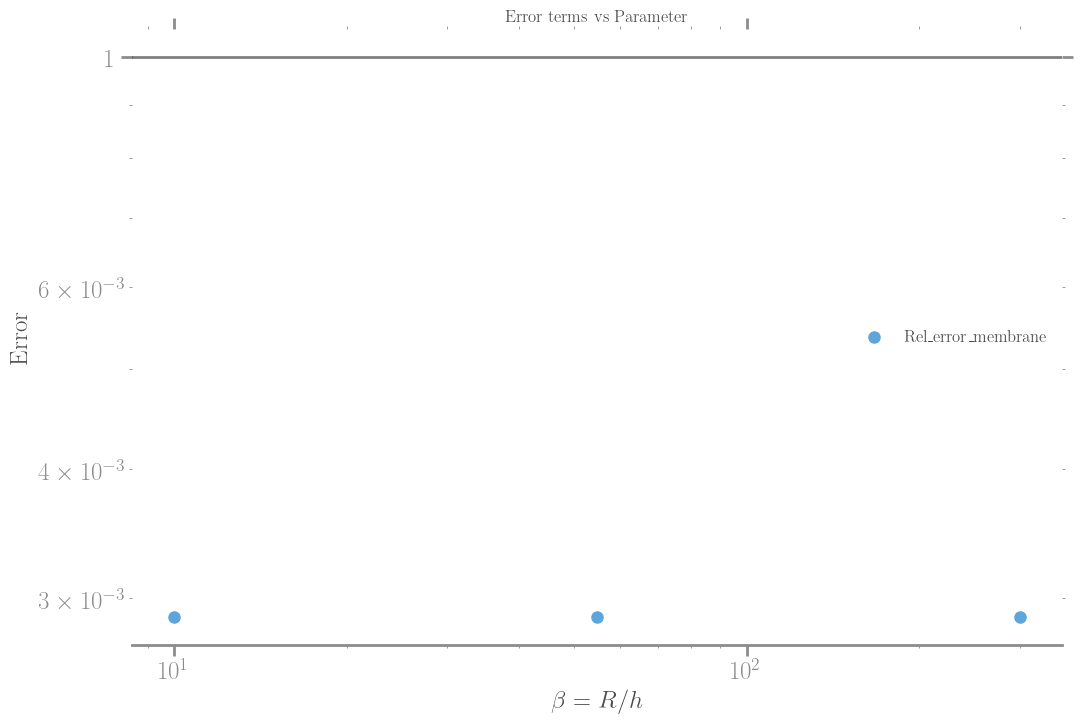

In [ ]:

fig, axs = plot_error_terms(experimental_data, error_terms=["rel_error_membrane"])
visuals.setspines0()
# fig.savefig(f"{output_folder}/{series}_error_terms.pdf", bbox_inches='tight')
axs.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%} %'.format(y))) 
axs.axhline(0.01, color='k', linestyle='-', alpha=0.5)
visuals.setspines0()
fig.savefig(f"{output_folder}/{series}_error_terms.pdf", bbox_inches='tight')
fig.savefig(f"{output_folder}/{series}_error_terms.png", bbox_inches='tight')


## Verification, polynomial transverse load

In [ ]:
def exact_energy_transverse_bending(parameters, h, adimensional=True):
    # it should depend on the signs as well
    c_nu = 1/(12 * (1 - parameters["model"]["nu"] ** 2))
    
    energy_scale = 1
    if adimensional:
        energy_scale = parameters["model"]["E"] * h ** 5 / parameters["geometry"]["radius"] ** 2    
    return (
        1/energy_scale
        * 64 / 3 * parameters["model"]["E"] * h ** 5 * np.pi * c_nu ** 2
    )
    
def exact_energy_transverse_membrane(parameters, h, adimensional=True):
    # it should depend on the signs as well
    c_nu = 1/(12 * (1 - parameters["model"]["nu"] ** 2))
    
    energy_scale = 1
    if adimensional:
        energy_scale = parameters["model"]["E"] * h ** 5 / parameters["geometry"]["radius"] ** 2    
    return (
        1/energy_scale
        * 2 / 7 * parameters["model"]["E"] * h ** 5 * np.pi * c_nu ** 2
    )
    
    

In [207]:
# data_file = "experiment_parametric_transverse/output/d8cb39/experimental_data.pkl"  # Update with your file path
data_file = "experiment_parametric_transverse/output/909867/experimental_data.pkl"  # Update with your file path
experimental_data = pd.read_pickle(data_file)

series = data_file.split("/")[-2]
output_folder = os.path.join(*[s for s in os.path.dirname(data_file).split('/')[0:2]])

experimental_folder = os.path.dirname(data_file)

with open(os.path.join(experimental_folder, 'parameters.yaml')) as f:
    parameters = yaml.load(f, Loader=yaml.FullLoader)

# assert parameters["model"]["higher_regularity"] == True

# Display basic information about the dataset
print("Loaded Data Information:")
print(experimental_data.info())

# ## Data Overview
# Show the first few rows of the data for an overview
display(experimental_data.head())


Loaded Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   signature                  3 non-null      object 
 1   param_value                3 non-null      float64
 2   total                      3 non-null      float64
 3   bending                    3 non-null      float64
 4   membrane                   3 non-null      float64
 5   coupling                   3 non-null      float64
 6   v_L2                       3 non-null      float64
 7   w_L2                       3 non-null      float64
 8   v_H1                       3 non-null      float64
 9   w_H1                       3 non-null      float64
 10  v_H2                       3 non-null      float64
 11  w_H2                       3 non-null      float64
 12  abs_error_membrane         3 non-null      float64
 13  abs_error_bending          3 

,signature,param_value,total,bending,membrane,coupling,v_L2,w_L2,v_H1,w_H1,...,bcv,bcw,snes_iterations,snes_convergence_reason,snes_final_residual_norm,snes_function_evaluations,ksp_iterations_last,ksp_convergence_reason,ksp_final_residual_norm,ksp_type
0,066bbe33dd6efad0bb62056995f58108,10.000000,0.494591,0.487939,0.006643,0.013295,0.010972,0.328917,0.032075,0.910626,...,-5.492124e-07,-0.001524,5,4,8.708939e-09,6,1,4,0.0,preonly
1,26c94977e5f23ad287cd9ab2263f1841,31.622777,0.494591,0.487939,0.006643,0.013295,0.010972,0.328917,0.032075,0.910626,...,-5.492124e-07,-0.001524,5,4,8.708939e-09,6,1,4,0.0,preonly
2,a43edf06bfeea0e16e81c50e604f4fad,100.000000,0.494591,0.487939,0.006643,0.013295,0.010972,0.328917,0.032075,0.910626,...,-5.492124e-07,-0.001524,5,4,8.708939e-09,6,1,4,0.0,preonly


Saved to experiment_parametric_transverse/output/909867_energy_terms


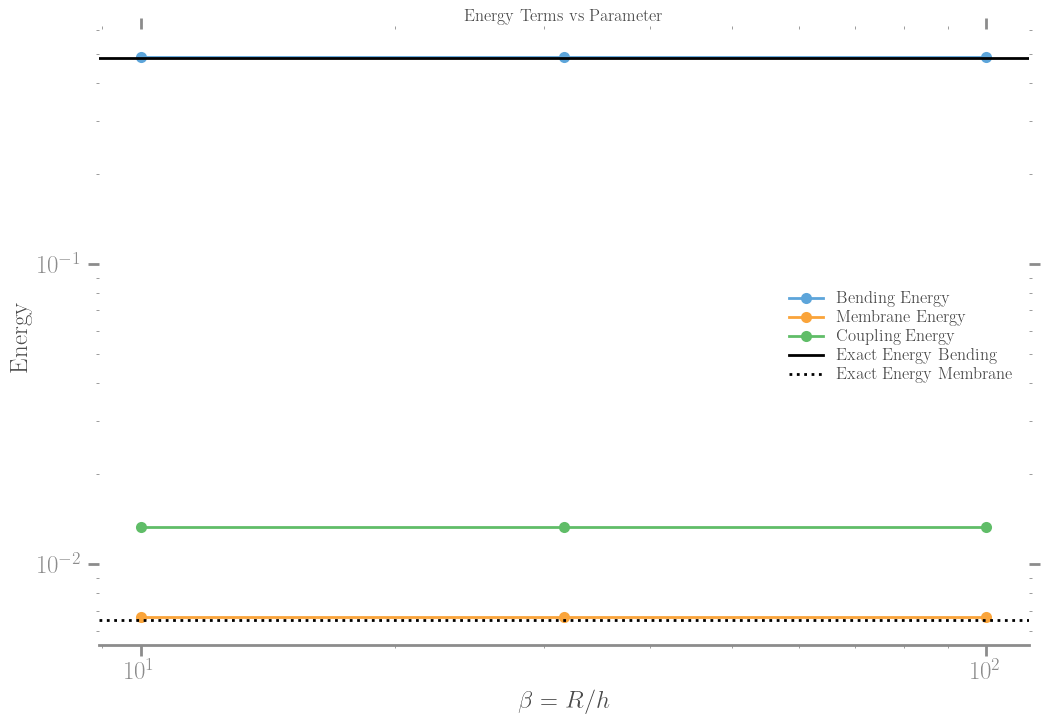

In [209]:

fig, axs = plot_energy_terms(experimental_data, energy_terms=["bending", "membrane", "coupling"])
# axs.set_ylim(1e-1, 1e0)
axs.axhline(exact_energy_transverse_bending(parameters, .01), c='k', label="Exact Energy Bending")
axs.axhline(exact_energy_transverse_membrane(parameters, .1), c='k', ls=':', label="Exact Energy Membrane")

axs.legend()
visuals.setspines0()

fig.savefig(f"{output_folder}/{series}_energy_terms.pdf", bbox_inches='tight')
fig.savefig(f"{output_folder}/{series}_energy_terms.png", bbox_inches='tight')
print(f"Saved to {output_folder}/{series}_energy_terms")


Saved to experiment_parametric_transverse/output/909867_error_terms


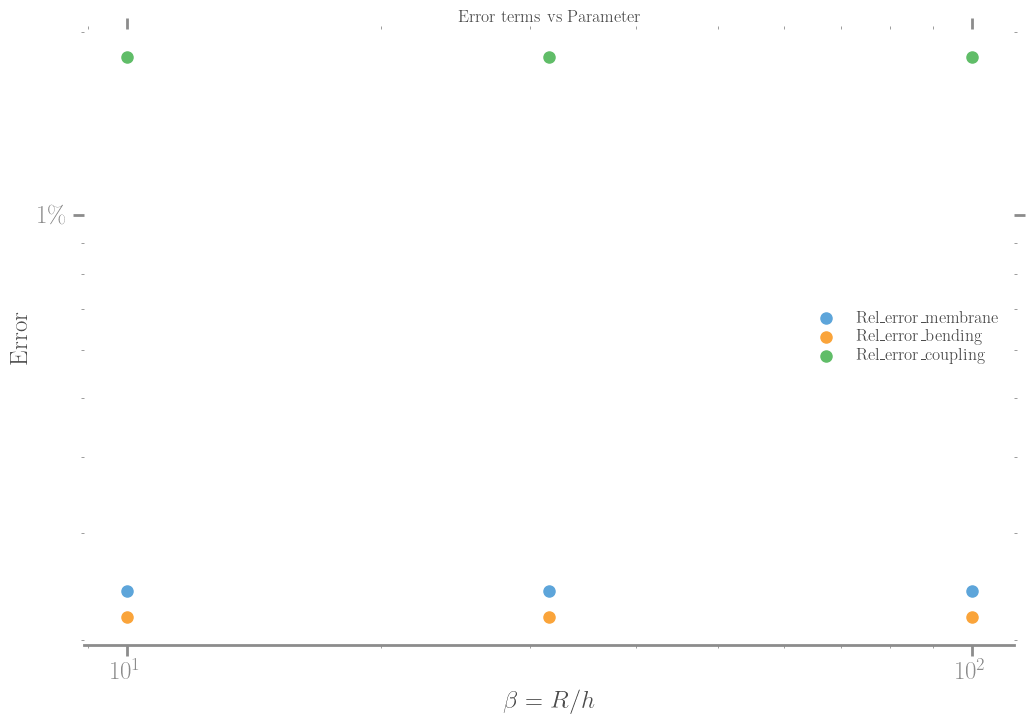

In [210]:
fig, axs = plot_error_terms(experimental_data)
visuals.setspines0()
fig.savefig(f"{output_folder}/{series}_error_terms.pdf", bbox_inches='tight')
fig.savefig(f"{output_folder}/{series}_error_terms.png", bbox_inches='tight')
print(f"Saved to {output_folder}/{series}_error_terms")


In [ ]:
experimental_data[["abs_error_membrane", "abs_error_bending", "abs_error_coupling"]], parameters["geometry"]["mesh_size"]

(   abs_error_membrane  abs_error_bending  abs_error_coupling
 0            0.001187           0.001059            0.000119
 1            0.001187           0.001059            0.000119
 2            0.001187           0.001059            0.000119,
 0.03)

In [ ]:
experimental_data[["abs_error_membrane", "abs_error_bending", "abs_error_coupling"]], parameters["geometry"]["mesh_size"]

(   abs_error_membrane  abs_error_bending  abs_error_coupling
 0            0.002089           0.001967             0.00011
 1            0.002089           0.001967             0.00011
 2            0.002089           0.001967             0.00011
 3            0.002089           0.001967             0.00011
 4            0.002089           0.001967             0.00011
 5            0.002089           0.001967             0.00011
 6            0.002089           0.001967             0.00011
 7            0.002089           0.001967             0.00011
 8            0.002089           0.001967             0.00011
 9            0.002089           0.001967             0.00011,
 0.05)